# Import dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from datetime import datetime
import random
import pickle

In [2]:
# Corpus
df = pd.read_csv('full_content_QD.csv' , index_col=0)

# HSI
std_resid = pd.read_csv('HSI_with_GARCH_resid.csv', index_col=0)

In [3]:
df_original = pd.read_csv('content_cleaned_original.csv', index_col=0)

In [40]:
df.rename(columns={'body': 'content'}, inplace=True)

In [44]:
# Join the dataframe to prepare the finalised dataframe
joined_df = df.join(std_resid['abs_resid']).reset_index()

# Deal with the news releasing dates which are non-trading days
index = 0
for ix, row in joined_df.iterrows():
    is_na = pd.isna(joined_df.loc[ix, 'abs_resid'])
    if not is_na:
        index = ix
    if is_na:
        joined_df.loc[ix, 'index'] = joined_df.loc[index, 'index']

In [45]:
joined_df.rename(columns={'index': 'date'}, inplace=True)
trading_days = joined_df.set_index('date')

In [46]:
trading_days.drop(columns='abs_resid', inplace=True)

# Model

### rolling_LDA

In [69]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
from sklearn.linear_model import LinearRegression
import re
from statsmodels.tsa.arima_model import ARIMA


class rolling_LDA:
    """
    This is a class to conduct LDA in each period and generate a dictionary and/or wordsclouds for comparison
    - dataframe --> input dataframe (The index should be dates, values should be the cleaned news for each observation)
    - start --> start date of the entire period (in str)
    - end --> end date of the entire period (in str)
    - window_size --> size of the rolling window
    - roll_size --> the step size of the rolling window
    - n_topics --> number of topics generated in each year
    - max_df --> the threshold for data filtering: those appear more than max_df% of documents are ignored
    - min_df --> the threshold for data filtering: those appear less than min_df% of documents are ignored
    - top_n_words --> the top n components to display in each topic
    - vectorizer --> 'count' or 'tfidf'
    - show_wordclouds --> to display wordcloud as the output or not
    """
    
    
    def __init__(self, dataframe, start, end, window_size, roll_size, score = 'all', top_n_words = None, n_topics = None, max_df = None, min_df = None, vectorizer = 'count'):
        self.dataframe = dataframe
        self.start = start
        self.end = end
        self.window_size = window_size
        self.roll_size = roll_size
        self.n_topics = n_topics
        self.score = score
        self.max_df = max_df
        self.min_df = min_df
        self.top_n_words = top_n_words
        self.vectorizer = vectorizer
        self.content = None # To be declared
        self.lda_df = None # To be declared
        self.doc_topic_matrix = None # To be declared
        self.doc_mean_df = pd.DataFrame() # To be declared
        self.doc_gini_df = pd.DataFrame() # To be declared
        self.topic_gini_df = pd.DataFrame() # To be declared
        self.diversity_ranked_topics_df = pd.DataFrame() # To be declared
        self.dictionary = None # To be declared
        self.labels = None # To be declared
        self.diversity_label = None # TO be declared
        self.end_index = 0
        self.doc_topic_df = None
        self.last_date = None
        self.doc_length = pd.Series()
        self.word_appearence = pd.Series()
        self.DTM = None
        self.last_index = 0

        
    # (Main) Find all words appeared in the topics in the period and plot the distribution of probability of words in each year
    def period_summary(self):
        
        # Declare the variables
        df = self.dataframe
        top_n_words = self.top_n_words
        vectorizer = self.vectorizer
        
        # Set window size
        start_date = datetime.strptime(self.start, '%Y-%m-%d')
        end_date = datetime.strptime(self.end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=self.window_size)
        rs = self.roll_size
        
        # Set the df index to datetime
        df.index = pd.to_datetime(df.index)
        df['index'] = df.reset_index().index
        
        # Create item to store the years, topics, words and probability
        summary_d = {}

        # Roll the window to do LDA
        period = 0 # To create the column names for doc_top_df
        while roll_end <= end_date:
            window = df[(df.index >= roll_start) & (df.index <= roll_end)]
            
            # Track the index
            try:
                index = list(window.index)[-1]
            except:
                continue
            if index == self.end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                self.end_index = index
                pass
        
            # Print current work
            print("Period", str(roll_start) + " to " +str(roll_end))
            
            # Run LDA in the window
            content = window.content
            self.content = content

            self.LDA_tf(window['index'])
            
            # Document-topic matrix
            doc_top_df = pd.DataFrame(self.doc_topic_matrix, index = content.index)
            
            # Rank the topics by mean
            ranking = doc_top_df.mean()
            labels = list(ranking.rank(ascending=0).sort_values().index)
            self.labels = labels # This is defined for ranking topic word distributions as well
            doc_top_df = doc_top_df[labels]
            doc_top_df.columns = list(range(self.doc_topic_matrix.shape[1]))
                 
            # Extract last date of the window
            last_date = list(doc_top_df.index)[-1]
            self.last_date = last_date
            
            # Calculate the topic score by taking into account of mean
            self.doc_top_df = doc_top_df
            topic_score_mean = self.Topic_Score_Calculation()
            
            # Calculate the gini coefficient as the topic score
            p_square = doc_top_df**2
            doc_gini = 1 - p_square.sum(axis = 1)
            doc_top_df = doc_gini.to_frame()
            doc_top_df.columns = ['gini']
            self.doc_top_df = doc_top_df
            topic_score_gini = self.Topic_Score_Calculation()
            
            # Concat
            #self.doc_topic_df = pd.concat([self.doc_topic_df,doc_top_df], axis = 1, sort = False)
            self.doc_mean_df = pd.concat([self.doc_mean_df,topic_score_mean])
            self.doc_gini_df = pd.concat([self.doc_gini_df,topic_score_gini])
            
            # Topic-word-probability-matrix
            d = self.top_n_words_each_topic()

            if self.top_n_words != None:
                # Import data to the summary dictionary
                timeframe = str(roll_start.date()) + " to " + str(roll_end.date())
                summary_d[timeframe] = d
            else:
                topic_gini = pd.DataFrame(index = [last_date], columns = list(range(self.doc_topic_matrix.shape[1])))
                for topic in list(topic_gini.columns):
                    N = len(d[topic])
                    gini = sum([(x[1]**2)*N for x in d[topic]])
                    topic_gini.loc[last_date,topic] = gini
                self.topic_gini_df = pd.concat([self.topic_gini_df, topic_gini])
                
            # Rank topics by diversity
            if self.top_n_words == None:
                diversity_label = list(topic_gini.T.rank(ascending=0).iloc[:,0].sort_values().index)
                diversity_ranked_topics = topic_gini[diversity_label]
                diversity_ranked_topics.columns = list(range(diversity_ranked_topics.shape[1]))
                self.diversity_ranked_topics_df = pd.concat([self.diversity_ranked_topics_df, diversity_ranked_topics])
                
            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)
                                      
            # Add one to the period index
            period += 1

        # After rolling the window
        if self.top_n_words != None:
            word_freq = summary_d
        else:
            word_freq = self.topic_gini_df
        
        return word_freq, self.doc_mean_df, self.doc_gini_df, self.diversity_ranked_topics_df
    
            
    # (Peripheral) LDA for tf matrix
    def LDA_tf(self, index):

        # Declare the variables
        content = self.content
        n_topics = self.n_topics
        vectorizer = self.vectorizer        
        
        # Allow choosing tfidf, default is TF
        # Make tf from the corpus
        if self.max_df != None and self.min_df != None and self.n_topics != None:
            max_df, min_df, n_components = self.max_df, self.min_df, self.n_topics
        else:
            max_df, min_df, n_components = self.optimal_params(content, vectorizer, n_topics)
        
        # Run the optimal LDA
        if vectorizer == 'tfidf':
            vec = TfidfVectorizer(max_df=max_df,min_df=min_df)
        else:
            vec = CountVectorizer(max_df=max_df,min_df=min_df)
        tf = vec.fit_transform(content)
        
        
        # get document term matrix
        columns = vec.get_feature_names()
        DTM = np.array(tf.toarray())
        self.DTM = DTM
        DocSeries = pd.Series((DTM>0).sum(axis=1), index=index)
        self.doc_length = self.doc_length.combine(DocSeries, max, fill_value=0) 
        WordSeries = pd.Series((DTM[self.last_index:]).sum(axis=0), index=columns)
        self.word_appearence = self.word_appearence.add(WordSeries, fill_value=0)
        self.last_index = index[-1] + 1

        
        lda = LatentDirichletAllocation(n_components = n_components)
        lda.fit(tf)
        
        # Compute document topic matrix
        doc_topic_matrix = lda.fit_transform(tf).round(3)

        # Compute probability of words
        probs = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

        # Create data frame of the lda model
        lda_df = pd.DataFrame(lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis], columns = columns)
        
        # Return the matrixes
        self.lda_df = lda_df
        self.doc_topic_matrix = doc_topic_matrix
    
    # (Peripheral) Find the optimal number of topics for each period
    def optimal_params(self, content, vectorizer, n_topics):
    
        if self.max_df != None and self.min_df != None:
            max_df = [self.max_df]
            min_df = [self.min_df]
        else:
            max_df = list(np.linspace(0.2,0.3,5))
            min_df = list(np.linspace(0.0001,0.001,5))

        log_likelihood = {}

        # Loop for 15 times to calculate the best max_df, min_df and n_components
        for loop in range(15):
            for x in max_df:
                for y in min_df:            
                    if vectorizer == 'tfidf':
                        vec = TfidfVectorizer(max_df=x,min_df=y)
                    else:
                        vec = CountVectorizer(max_df=x,min_df=y)
                    
                    tf = vec.fit_transform(content)

                    # If number of topics is set, no loop for topic
                    if n_topics != None:
                        lda = LatentDirichletAllocation(n_components = n_topics)
                        lda.fit(tf)
                        tup = (x,y,n_topics)
                        if tup in list(log_likelihood.keys()):
                            log_likelihood[tup] = log_likelihood[tup] + lda.score(tf)
                        else:
                            log_likelihood[tup] = lda.score(tf)
                        
                    # If number of topics not set, do loop
                    else:
                        for i in range(6, 15, 2):
                            lda = LatentDirichletAllocation(n_components = i)
                            lda.fit(tf)

                            tup = (x,y,i)

                            if tup in list(log_likelihood.keys()):
                                log_likelihood[tup] = log_likelihood[tup] + lda.score(tf)
                            else:
                                log_likelihood[tup] = lda.score(tf)
                                  
                                
            print(str((loop+1)*6) + '%' + 'Done')

        opt_params = sorted(log_likelihood.items(), key=lambda x: x[1], reverse=True)[0][0]
        print(opt_params)
        
        self.max_df = opt_params[0]
        self.min_df = opt_params[1]
        
        return opt_params[0], opt_params[1], opt_params[2]
 

    # (Peripheral) Find top n words in each topic for each period
    def top_n_words_each_topic(self):
        
        # Declare the variables
        lda_df = self.lda_df
        n = self.top_n_words
        
        # Rank the lda_df
        lda_df = lda_df.T
        lda_df = lda_df[self.labels]
        lda_df.columns = list(range(lda_df.shape[1]))
        lda_df = lda_df.T
        
        # Create dictionary to store topic, words and probability
        d = {}
        for i in range(len(lda_df)):
            if n != None:
                row_topn = lda_df.iloc[i,:].sort_values(ascending = False)[:n]
            else:
                row_topn = lda_df.iloc[i,:].sort_values(ascending = False)
            word = row_topn.index.tolist()
            prob = row_topn.values.tolist()
            tup = list(tuple(zip(word,prob)))
            d[i] = tup

        self.dictionary = d
        return d
    
    def Topic_Score_Calculation(self):
        
        # Define the input variables
        doc_top_df = self.doc_top_df
        last_date = self.last_date
        
        if self.score == 'single':
            # (1) Calculate topic score on the last date - use documents in the last day only
            try:
                topic_scores = doc_top_df.loc[last_date].mean().to_frame().T
                topic_scores.index = [last_date]
            except:
                topic_scores = doc_top_df.loc[last_date].to_frame().T

        elif self.score == 'all':
            # (2) Calculate topic score on the last date - average of all documents in the window
            topic_scores = doc_top_df.mean().to_frame().T
            topic_scores.index = [last_date]
            
        return topic_scores

        
    
    # (Optional function) Creat graphs
    @staticmethod
    def LDA_graphs(summary_d, n_words = 10, kind = 'wordcloud'):
        
        """ The dictionary is the output of rolling_LDA().period_summary()"""
        """ 
        kind = 'wordcloud' (default) --> generate wordcloud
        kind = 'bar' --> generate horizontal barchart
        """
           
        dictionary = summary_d
        
        period_names = list(dictionary.keys())
        period_values = list(dictionary.values())
        
        # Declare the variables
        for p_name, p_values in zip(period_names,period_values):

            pic_height = 5*np.ceil(len(p_values)/4)
            fig = plt.figure(figsize = (20,pic_height))
            
            for i in range(len(p_values)):
                d = {}
                for wp in p_values[i]:
                    w = wp[0]
                    p = wp[1]
                    d[w] = p
                    if len(d) >= n_words:
                        break

                n = np.ceil(len(p_values)/4)
                ax = plt.subplot(n,4,i+1)
                ax.set_title("Topic #" + str(i))
                
                if kind == 'bar':
                    plt.barh(list(d.keys()),list(d.values()))
                    plt.xticks(ticks =[])
                    plt.yticks(fontsize = 8)
                    ax.spines['right'].set_visible(False)
                    ax.spines['top'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.spines['left'].set_visible(False)
                    for i in ax.patches:
                        ax.text(i.get_width() , i.get_y() + 0.25, str(round((i.get_width()), 4)), fontsize=8, color='black')
                else:
                    wordcloud = WordCloud(width = 500, height= 500, max_font_size=60,max_words=100, background_color='white')
                    wordcloud.generate_from_frequencies(frequencies=d)
                    plt.imshow(wordcloud,interpolation="bilinear")
                    plt.axis("off")
            
            plt.suptitle(str(p_name))
            plt.show()

### rolling_analysis

In [12]:
class rolling_analysis:
    
    def __init__(self, df, std_resid, start, end, window_size, roll_size, threshold = 0.5, lag = 5):
        
        """
        df --> topics generated from rolling_LDA
        std_resid --> a dataframe of residual
        start --> start date of the period to analyse
        end --> end date of the period to analyse
        window_size --> size of the rolling window
        roll_size --> step size of each move in the rolling analysis
        threshold --> Show lines exceeding the threshold only in linked_top_line_plot()
        """  
        
        self.df = df
        self.std_resid = std_resid
        self.start = start
        self.end = end
        self.window_size = window_size
        self.roll_size = roll_size
        self.threshold = threshold
        self.lag = lag + 1
        self.end_index = 0 # To be declared
            
  
    def Multiple_Correlations(self):
        """
        top_by_period --> topics generated from rolling_LDA
        resid --> dataframe of the residual
        start --> start date of the analysis
        end --> end date of the analysis
        window_size --> size of the rolling window
        rs --> step size or roll size of the rolling window
        -------------------------------------------------------
        Return: topic multiple correlation, lag multiple correlation, a list of rolled windows
        """

        # Set all attributes
        start = self.start
        end = self.end
        rs = self.roll_size
        top_by_period = self.df
        resid = self.std_resid
        window_size = self.window_size
        top_by_period.columns = [float(x) for x in list(top_by_period.columns)]

        # Set the df index to datetime
        top_by_period.index = pd.to_datetime(top_by_period.index)

        # Create a dataframe to store all the lagged_topics
        full_df = pd.DataFrame()

        for topic in top_by_period.columns:
            topic_df = top_by_period[[topic]]
            # Create shift 1 to lag in the dataframe of each topic
            for lag in range(1,self.lag):
                col_name = str(topic) + "t-" + str(lag)
                topic_df[col_name] = topic_df.iloc[:,0].shift(lag)
            full_df = pd.concat([full_df,topic_df], axis=1)

        # Attach the residual column to the full dataframe
        full_df = full_df.join(resid).fillna(method='ffill').dropna()

        # Create a dictionary to store the mult_corr
        top_mult_corr = {}
        lag_mult_corr = {}

        # Create timeframe to track the period
        timeframes = []

        # Roll the window
        start_date = datetime.strptime(start, '%Y-%m-%d')
        end_date = datetime.strptime(end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        
        while roll_end <= end_date:
            window = full_df[(full_df.index >= roll_start) & (full_df.index < roll_end)]
            
            # Track the index
            index = list(window.index)[-1]
            if index == self.end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                self.end_index = index
                pass

            # Print current work
            timeframe = str(roll_start) + " to " + str(roll_end)
            timeframes.append(timeframe)
            # print(timeframe)

            # Find multiple correlation for the topics
            for topic in top_by_period.columns:
                re_pattern = '^' + str(topic)
                topic_cols = list(set([x for x in list(window.columns) if re.findall(re_pattern, str(x))]) - set([topic]))
                X = window[topic_cols]
                Y = window.iloc[:,-1]
                fit = LinearRegression().fit(X,Y)
                R_sq = fit.score(X,Y)
                mult_corr = np.sqrt(R_sq)
                # Add the value to the dictionary
                if topic not in top_mult_corr.keys():
                    top_mult_corr[topic] = [mult_corr]
                else:
                    top_mult_corr[topic].append(mult_corr)

            # Find multiple correlation for the lags
            for lag in range(self.lag):
                if lag == 0:
                    re_pattern = '\d+\.0$'
                else:
                    re_pattern = '.+' + 't-' + str(lag) + '$'
                topic_cols = [x for x in list(window.columns) if re.findall(re_pattern, str(x))]
                X = window[topic_cols]
                Y = window.iloc[:,-1]
                fit = LinearRegression().fit(X,Y)
                R_sq = fit.score(X,Y)
                mult_corr = np.sqrt(R_sq)
                # Add the value to the dictionary
                if lag not in lag_mult_corr.keys():
                    lag_mult_corr[lag] = [mult_corr]
                else:
                    lag_mult_corr[lag].append(mult_corr)

            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)

        return full_df, top_mult_corr, lag_mult_corr, timeframes


    def Single_Correlation(self):
        start_date = datetime.strptime(self.start, '%Y-%m-%d')
        end_date = datetime.strptime(self.end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=self.window_size)
        rs = self.roll_size

        # Set the df index to datetime
        self.df.index = pd.to_datetime(self.df.index)

        # Create a dataframe to store all correlations
        corr_df = pd.DataFrame()
        timeframes = []
        
        # Roll the window to show graphs and correlations
        period = 0
        while roll_end <= end_date:
            window = self.df[(self.df.index >= roll_start) & (self.df.index < roll_end)]
            
            # Track the index
            index = list(window.index)[-1]
            if index == self.end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                self.end_index = index
                pass

            # Print current work
            timeframe = str(roll_start) + " to " + str(roll_end)
            print("Period", timeframe)
            timeframes.append(timeframe)

            # Draw the graph and return the correlation
            
            corr = self.linked_top_line_plot(self.std_resid, window, self.threshold, lag= self.lag)
            new_index = ['P{}_'.format(str(period)) + str(int(x)) for x in list(corr.index)]
            corr.index = new_index
            corr_df = pd.concat([corr_df, corr])
            
            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)
            period += 1
            
        return corr_df, timeframes

    @staticmethod
    def mult_corr_graph(mult_corr_df, timeframes):
    
        mult_corr = pd.DataFrame.from_dict(mult_corr_df)

        new_list = [ls[0:10] for ls in timeframes]

        mult_corr.index = new_list

        plt.style.use('seaborn-darkgrid')
        plt.figure(figsize=(50,200))
        palette = plt.get_cmap('tab20')

        num=0

        for column in mult_corr:
            num+=1

            plt.subplot(mult_corr.shape[1],1, num)

            for v in mult_corr:
                mult_corr[v].plot(marker='', color='grey', linewidth=0.3, alpha=0.3)

            mult_corr[column].plot(marker='', color=palette(num), linewidth=3, alpha=1, label=column)

            #plt.xlim(0,54)
            #plt.ylim(0.45,1)

            plt.tick_params(axis='x', labelsize=20, rotation=70)
            plt.tick_params(axis='y', labelsize=20)

            plt.title(column, loc='left', fontsize=20, fontweight=10, color=palette(num))

    @staticmethod
    def linked_top_line_plot(std_resid, linked_topics, threshold, lag):
        lag = lag+1
        top_vol_df = linked_topics.join(std_resid).fillna(method = 'ffill').dropna()

        corr_df = pd.DataFrame()
        pass_topics = []

        grab_columns = top_vol_df

        # Create dataframe to store the correlations of lag_date

        lag_df = pd.DataFrame()

        for lag in range(0,lag):
            lag_resid = grab_columns[list(std_resid.columns)[0]].shift(-lag)
            lag_df_plot = grab_columns.iloc[:,:-1].join(lag_resid)
            lag_df_plot.dropna(inplace = True)

            # Calculate the correlation
            corr = lag_df_plot.corr().iloc[-1,:-1]
            lag_df[lag] = corr

        # extract the columns which satisfy the threshold for line chart
        pass_df = lag_df[(lag_df >= threshold) | (lag_df <= -threshold)]
        all_lag = list(pass_df[pass_df.sum(axis = 1) != 0].index)
        pass_topics.extend(all_lag)

        print(pass_df.dropna(how='all').dropna(axis=1,how='all'))

        corr_df = pd.concat([corr_df,lag_df])

        # Standardise the data for better comparison in the plot
        grab_rows = grab_columns.loc[grab_columns[grab_columns.columns[0]] != 0]
        grab_rows.dropna(inplace = True)
        grab_rows = (grab_rows - grab_rows.mean())/ grab_rows.std()

        # Plot the graphs
        try:
            fig, ax = plt.subplots(1,1, figsize=(20,5))
            topics_by_period_plot = grab_rows[list(pd.Series(all_lag).unique())]
            std_resid_plot = grab_rows.iloc[:,-1]

            topics_by_period_plot.plot(ax= ax, lw=0.3, alpha = 0.5)
            std_resid_plot.plot(ax= ax, lw= 1, legend = True, color = 'blue')
        except:
            pass

        #plt.savefig("Graph" + str(i) +".png", format="PNG")
        plt.title(str(list(linked_topics.index)[0]) + ' To ' + str(list(linked_topics.index)[-1]))
        plt.show()
        return corr_df

    @staticmethod
    def heatmap(corr_df, linewidth=0, ax = None):
        cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
        sns.heatmap(corr_df, annot = False, vmin=-1, vmax=1, center= 0, 
                    linewidths=linewidth, linecolor='grey', cmap = cmap, ax = ax, cbar = False)
        

    @staticmethod
    def rolling_statistics(HSI_df, start, end, window_size, roll_size):
        start_date = datetime.strptime(start, '%Y-%m-%d')
        end_date = datetime.strptime(end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        rs = roll_size

        # Set the df index to datetime
        HSI_df.index = pd.to_datetime(HSI_df.index)

        # Create storing objects
        rolling_mean_df = pd.DataFrame()
        rolling_var_df = pd.DataFrame()
        period_start = []
        period_end = []

        end_index = 0

        # Roll the window
        period = 0
        while roll_end <= end_date:
            window = HSI_df[(HSI_df.index >= roll_start) & (HSI_df.index < roll_end)]

            # Track the index
            index = list(window.index)[-1]
            if index == end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                end_index = index
                pass

            # Print current work        
            periodstart = window.index[0]
            period_start.append(periodstart)  
            periodend = window.index[-1]
            period_end.append(periodend)

            # Calculate the rolling statistics - mean
            rolling_mean = window.mean().to_frame().T
            rolling_mean.index = [period]
            rolling_mean_df = pd.concat([rolling_mean_df,rolling_mean])

            # Calculate the rolling statistics - variance
            rolling_var = window.var().to_frame().T
            rolling_var.index = [period]
            rolling_var_df = pd.concat([rolling_var_df, rolling_var])

            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)
            period += 1

        # Append period starts and ends back to the dataframes
        rolling_mean_df['period_start'] = period_start
        rolling_mean_df['period_end'] = period_end
        rolling_var_df['period_start'] = period_start
        rolling_var_df['period_end'] = period_end

        return rolling_mean_df, rolling_var_df
    
    @staticmethod
    def rolling_OOS_R2(predictions, start, end, window_size, roll_size):
        start_date = datetime.strptime(start, '%Y-%m-%d')
        end_date = datetime.strptime(end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        rs = roll_size

        # Set the df index to datetime
        predictions.index = pd.to_datetime(predictions.index)

        # Create storing objects
        R_sqs = []
        period_start = []
        period_end = []

        end_index = 0

        # Roll the window
        period = 0
        while roll_end <= end_date:
            window = predictions[(predictions.index >= roll_start) & (predictions.index < roll_end)]

            # Track the index
            if list(window.index) == []:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else: 
                index = list(window.index)[-1]
            if index == end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                end_index = index
                pass
                
            # Print current work        
            period_start.append(window.index[0])  
            period_end.append(window.index[-1])

            # Calculate the rolling OOS R_sq
            R_sq = 1 - (sum((window['true_y'] - window['predictions'])**2)/sum((window['true_y'] - window['benchmark'])**2))
            R_sqs.append(R_sq)

            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)
            period += 1

        output = pd.DataFrame({'OOS_R_sq':R_sqs,'period_start':period_start,'period_end':period_end})

        return output
    
    @staticmethod
    def ccf_plot(Y, topic_scores, p, K):

        # Settings
        number_of_columns = len(topic_scores.columns)
        fig_n_col = 5
        fig_n_row = int(np.ceil(number_of_columns/fig_n_col))
        fig, axs = plt.subplots(fig_n_row, fig_n_col, figsize = (20, int(fig_n_row*3)))

        for column in range(number_of_columns):
            # Create the AR model
            AR_model = ARIMA(topic_scores.iloc[:,column],(p,0,0)).fit(trend = 'nc')

            # Extract parammeter in the model with corresponding lags to calculate Y_tilde
            for ix, phi in enumerate(AR_model.params):
                lag = 'Y_t-{}'.format(ix+1)
                Y[lag] = Y.iloc[:,0].shift(ix+1)
                Y[lag] = Y[lag]*(-phi)
            Y_tilde = Y.dropna().sum(axis = 1).loc[topic_scores.index]

            # Calculate correlation between a_t-k and Y_tilde
            CORR_dict = {}
            for lag in range(-K,K):
                CORR = Y_tilde.corr(AR_model.resid.shift(lag))
                CORR_dict[lag] = CORR

            # Plot the correlation graph from k = -K to K 
            ax = axs[column//fig_n_col, column%fig_n_col]
            ax.bar(CORR_dict.keys(), CORR_dict.values())
            ax.set_ylim(-1,1)
            ax.axhline(0,color = 'red', linestyle = '--', lw = 0.3)
            ax.axvline(0,color = 'red', linestyle = '--', lw = 0.3)
            ax.set_title(topic_scores.columns[column])
        plt.show()
        
    @staticmethod
    def rolling_ccf_plot(Y, X, start, end, window_size, roll_size, p, K):
        
        start_date = datetime.strptime(start, '%Y-%m-%d')
        end_date = datetime.strptime(end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        rs = roll_size

        # Set the df index to datetime
        Y.index = pd.to_datetime(Y.index)
        X.index = pd.to_datetime(X.index)

        end_index = 0

        # Roll the window
        while roll_end <= end_date:
            window = X[(X.index >= roll_start) & (X.index < roll_end)]

            # Track the index
            if list(window.index) == []:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else: 
                index = list(window.index)[-1]
            if index == end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                end_index = index
                pass
                
            # Print current work  
            print(window.index[0], ':', window.index[-1])
            
            # Do the plotting
            rolling_analysis.ccf_plot(Y, window, p, K)

            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)

In [13]:
#Y = log(abs_resid)

### regression

In [14]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.linear_model import lasso_path
from sklearn.linear_model import Lasso
import warnings
from sklearn.preprocessing import StandardScaler
import itertools
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
import os
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.anova import anova_lm
warnings.filterwarnings("ignore")



class Regression:
    def __init__(self, start, end, roll_size):
        self.start = start
        self.end = end
        self.rs = roll_size
        self.Y = None
        self.X = None
        self.rolling_mean_df = None
        self.window_Y_test = None
        self.n = None
        self.interaction_terms = None
        self.p = None
        self.rolling_mean_y = None

    def fit(self, window_size, Y, X_list, decision_threshold , n, interaction_terms = False, p = 0, 
            rolling_mean_y = False, tolerance = 'high', X_inrange_rule = True, Y_inrange_rule = False, check_inf_obs = True):
        """
        Note that the input variables should have different column names
        """
        # Declare parameters
        end_index = 0
        start_date = datetime.strptime(self.start, '%Y-%m-%d')
        end_date = datetime.strptime(self.end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        self.n = n
        self.interaction_terms = interaction_terms
        self.p = p
        self.rolling_mean_y = rolling_mean_y

        # Join the input Xs together
        if X_list != []:
            X = pd.concat(X_list, axis = 1)
            params = pd.DataFrame(index = list(X.columns))
            self.X = X
        else:
            params = pd.DataFrame()
        self.Y = Y
        # For regression statistics of the final chosen model
        Regression_statistics = []
        predictions = pd.DataFrame(index = Y[Y.index >= str(roll_end)].index, columns = ['predictions','benchmark','true_y','acc_RMSE'])

        # Create rolling mean if necessary
        if rolling_mean_y == True:
            # Because start_date must be a window_size earlier, have to reset start_date for Y
            rolling_mean_start_date = start_date - timedelta(days=window_size+5)
            rolling_mean_start_date = str(rolling_mean_start_date.date())
            rolling_mean_df = self.rolling_mean_residual(Y, rolling_mean_start_date, self.end, window_size, self.rs)
            self.rolling_mean_df = rolling_mean_df
        
        while roll_end <= end_date:
            
            # Declare Y train
            window_Y = Y[(Y.index >= str(roll_start)) & (Y.index < str(roll_end))]
            
            # Prediction window - test sets of X and Y
            window_Y_test = Y[Y.index >= str(roll_end)].iloc[:1]
            self.window_Y_test = window_Y_test
            
            # Track the index
            index = list(window_Y.index)[-1]
            if index == end_index:
                roll_start = roll_start + timedelta(days = self.rs)
                roll_end = roll_end + timedelta(days=self.rs)
                continue
            else:
                end_index = index
                pass
            
            # Build and compare topic score models with the list of predictors (X) provided, else return benchmark model
            if X_list != []:
                window_X = X[(X.index >= str(roll_start)) & (X.index < str(roll_end))]
                sorted_models = self.Best_Subset_Regression(window_X, window_Y, n, interaction_terms, p, rolling_mean_y, check_inf_obs)
                # Determine the final model by checking whether X_test and prediction are within range
                best_topic_model, pred_from_topic_model = self.choose_appropriate_model(sorted_models, window_X, window_Y, tolerance, X_inrange_rule, Y_inrange_rule)  
            elif X_list == [] and rolling_mean_y == True:
                window_X = self.rolling_mean_df[(self.rolling_mean_df.index >= str(roll_start)) & (self.rolling_mean_df.index < str(roll_end))]
                if p > 0:
                    AR_to_add = self.create_lag_p_df(self.Y, p)
                    window_X = window_X.join(AR_to_add)
                fitted_model = self.simple_OLS(window_X, window_Y, has_constant = 'add')
                best_topic_model = (fitted_model, fitted_model.rsquared, None)
            else:
                best_topic_model = (None, -1, None)

            # Check whether best model is larger than the threshold
            if best_topic_model[1] >= decision_threshold and X_list != []:
                final_model = best_topic_model[0]
                final_model_name = 'Topic Scores'
                pred = pred_from_topic_model
            elif X_list == [] and rolling_mean_y == True:
                final_model = best_topic_model[0]
                final_model_name = 'Rolling Mean Y with Intercept'
                window_X_test = self.rolling_mean_df.loc[window_Y_test.index,:]
                if p > 0:
                    window_X_test = window_X_test.join(self.create_lag_p_df(Y, p)) 
                pred = final_model.predict(sm.add_constant(window_X_test, has_constant='add'))
            else:
                if rolling_mean_y == True:
                    window_X = self.rolling_mean_df[(self.rolling_mean_df.index >= str(roll_start)) & (self.rolling_mean_df.index < str(roll_end))]
                    final_model = self.simple_OLS(window_X, window_Y, has_constant = 'add')
                    final_model_name = 'benchmark'
                    window_X_test = self.rolling_mean_df.loc[window_Y_test.index,:]
                    pred = final_model.predict(sm.add_constant(window_X_test, has_constant='add'))
                else:
                    final_model = sm.OLS(window_Y, np.ones(window_Y.shape)).fit()
                    final_model_name = 'benchmark'
                    pred = window_Y.mean()
            
            # Append the regression statistics, parameters and prediction
            modelrsqaure, modelrsqaure_adj, fstat, db, modelskew, modelkurtosis, bp = self.regression_stats(final_model)
            if final_model_name == 'benchmark':
                modelrsqaure, modelrsqaure_adj = (0,0)
            statistics = (window_Y.index[0],window_Y.index[-1],final_model_name,modelrsqaure,modelrsqaure_adj,fstat,db,modelskew,modelkurtosis,bp)
            
            # Get the partial f-test - model
#             RSS_model = final_model.ssr
            
            # Save the chosen variables
            params[window_Y.index[-1]] = np.nan
            for variable, beta in zip(final_model.params.index, final_model.params.values):
                if variable in list(params.index):
                    params.loc[variable, window_Y.index[-1]] = beta
            # Benchmark model calculation
            if rolling_mean_y == True:
                benchmark_X = self.rolling_mean_df[(self.rolling_mean_df.index >= str(roll_start)) & (self.rolling_mean_df.index < str(roll_end))]
                benchmark_model = self.simple_OLS(benchmark_X, window_Y, has_constant = 'add')
                
                # Get the partial f-test - model
#                 RSS_benchmark_model = benchmark_model.ssr
                
                benchmark_X_test = self.rolling_mean_df.loc[window_Y_test.index,:]
                benchmark_pred = benchmark_model.predict(sm.add_constant(benchmark_X_test, has_constant='add'))
            else:
                benchmark_pred = window_Y.mean().values
            # Save the prediction results
            predictions.loc[window_Y_test.index, 'predictions'] = pred.values
            predictions.loc[window_Y_test.index, 'benchmark'] = benchmark_pred
            predictions.loc[window_Y_test.index, 'true_y'] = window_Y_test.values
            
            # Calculate the partial F-test from the 2 RSS
            if rolling_mean_y:
                Partial_F = final_model.compare_f_test(benchmark_model)[1]
#                 Partial_F = ((RSS_benchmark_model - RSS_model)/n)/(RSS_model/(window_Y.shape[0]-(2+n)))
                statistics = statistics + (Partial_F,)
            
            Regression_statistics.append(statistics)
            
            # Calculate the accumulated RMSE
            acc_RMSE = Regression.prediction_performance(predictions[['predictions','benchmark','true_y']].dropna())['RMSE_with_topic_score']
            predictions.loc[window_Y_test.index, 'acc_RMSE'] = acc_RMSE
                  
            # Move the window
            roll_start = roll_start + timedelta(days = self.rs)
            roll_end = roll_end + timedelta(days= self.rs)


        # Create Dataframe to organsize all results
        data_dict = {'period_start':[x[0] for x in Regression_statistics],
                       'period_end':[x[1] for x in Regression_statistics],
                       'model_name': [x[2] for x in Regression_statistics],
                       'rsquare':[x[3] for x in Regression_statistics],'adj_rsquare':[x[4] for x in Regression_statistics],
                       'f_statistic_p_val':[x[5] for x in Regression_statistics], 'durbinwatson':[x[6] for x in Regression_statistics], 
                       'skewness':[x[7] for x in Regression_statistics],'kurtosis':[x[8] for x in Regression_statistics],
                       'breusch_pagan_p_val':[x[9] for x in Regression_statistics]}
        
        if rolling_mean_y:
            data_dict['Partial_F'] = [x[10] for x in Regression_statistics]
            
        model_stat = pd.DataFrame(data_dict)

        
        predictions['predictions']= predictions['predictions'].astype('float')
        predictions['benchmark'] = predictions['benchmark'].astype('float')
        predictions['true_y'] = predictions['true_y'].astype('float')
        predictions['acc_RMSE'] = predictions['acc_RMSE'].astype('float')
        
        return model_stat, params.T, predictions
         
    def regression_stats(self, results):
        modelrsqaure = results.rsquared
        modelrsqaure_adj = results.rsquared_adj
        fstat = results.f_pvalue
        db = durbin_watson(results.resid)
        modelskew = skew(results.resid_pearson)
        modelkurtosis= stats.kurtosis(results.resid,fisher=False)
        bp=het_breuschpagan(results.resid, results.model.exog)
        return modelrsqaure, modelrsqaure_adj, fstat, db, modelskew, modelkurtosis, bp[-1]
    
    def simple_OLS(self, window_X, window_Y, has_constant = 'None'):
        model = sm.OLS(window_Y, sm.add_constant(window_X, has_constant=has_constant))
        results = model.fit()
        return results
        
    def Best_Subset_Regression(self, window_X, window_Y, n, interaction_terms, p, rolling_mean_y, check_inf_obs):
        # Create list to store the performance
        R2_list = []
        
        # Create subset variables as the X of the regression
        combs = list(combinations(list(window_X.columns), n))
        for comb in combs:
            subset_variables = window_X[list(comb)]
            
            # Set interaction term if necessary
            if n > 1 and interaction_terms == True:
                subset_variables = self.Add_interaction_terms(subset_variables)
                
            if p > 0:
                # Create a dataframe with lag (p) and join to the variable
                AR_to_add = self.create_lag_p_df(self.Y, p)
                subset_variables = subset_variables.join(AR_to_add)
                
            # if rolling mean == True then join rolling mean
            if rolling_mean_y == True:
                subset_variables = subset_variables.join(self.rolling_mean_df)

            # Call Regression and store the result
            fitted_model = self.simple_OLS(subset_variables, window_Y, has_constant = 'add')
            
            # Check whether there are inflential observations, if exists then drop it and rerun regression
            exist_inf_obs = self.check_influential_obs(fitted_model)
            if check_inf_obs == True:
                if exist_inf_obs[0]:
                    subset_variables = subset_variables.drop(exist_inf_obs[1])
                    refined_window_Y = window_Y.drop(exist_inf_obs[1])
                    fitted_model = self.simple_OLS(subset_variables, refined_window_Y, has_constant = 'add')
            
            R2_list.append((fitted_model, fitted_model.rsquared, list(comb)))
            
        # Sort models by R2
        sorted_models = sorted(R2_list, key=lambda x: x[1], reverse=True)
                
        return sorted_models
    
    def choose_appropriate_model(self, sorted_models, window_X, window_Y, tolerance, X_inrange_rule, Y_inrange_rule):
        best_topic_model = (None, -1, None)
        pred = None
        for model in sorted_models:
            # Predict with each model
            final_model = model[0]
            window_X_test = self.X.loc[self.window_Y_test.index,:][model[2]]
            if self.n > 1 and self.interaction_terms == True:
                window_X_test = self.Add_interaction_terms(window_X_test)
            if self.p > 0:
                window_X_test = window_X_test.join(self.create_lag_p_df(self.Y, self.p)) 
            if self.rolling_mean_y == True:
                window_X_test = window_X_test.join(self.rolling_mean_df)
            pred = final_model.predict(sm.add_constant(window_X_test, has_constant='add'))
            # If prediction and X_Test satistfy the criteria then return the final model
            finalise = True
            
            # ignore switching to another model if all features are put into the model, i.e. n = number of columns in x
            if self.n < 10: # n should not be larger than 2 normally, just put this to address the issue above
                if X_inrange_rule == True:
                    if not self.X_test_within_range(window_X, model[2]):
                        finalise = False
                if Y_inrange_rule == True:
                    if not self.pred_within_range(pred, window_Y):
                        finalise = False
            if finalise == True:
                best_topic_model = model
                break
            else:
                if tolerance == 'high':
                    continue
                elif tolerance == 'low':
                    best_topic_model = (None, -1, None)
                    break
        # Return all things we need
        return best_topic_model, pred
    
    def COOKD_Filtering_Criteria(self, COOKD):
        By_one = ((COOKD >= 1).any(), COOKD[COOKD >= 1].index)
        return By_one

    def check_influential_obs(self, fitted_model):
        COOKD = OLSInfluence(fitted_model).cooks_distance[0]
        criterion = ((COOKD >= 1).any(), COOKD[COOKD >= 1].index)
        return criterion
        
    def pred_within_range(self, prediction, window_Y):
        within_range = True
        max_val = window_Y.max().values
        min_val = window_Y.min().values
        if prediction.values < min_val or prediction.values > max_val:
            within_range = False
        return within_range   
    
    def X_test_within_range(self, window_X, used_predictors):
        within_range = True
        for predictor in used_predictors:
            X_to_view = window_X[predictor]
            X_test_val = self.X.loc[self.window_Y_test.index,predictor].values
            max_val = X_to_view.max()
            min_val = X_to_view.min()
            if X_test_val < min_val or X_test_val > max_val:
                within_range = False
        return within_range
    

    def Add_interaction_terms(self, variables):
        nC2_to_interact = list(combinations(list(variables.columns), 2))
        for combination in nC2_to_interact:
            interaction_name = "*".join([str(x) for x in combination])
            variables[interaction_name] = variables[list(combination)].prod(axis = 1)
        return variables
    
    def create_lag_p_df(self, input_y, p):
        output = pd.DataFrame(index = input_y.index)
        for i in range(1, p+1):
            name = 'Y_t-{}'.format(i)
            output[name] = input_y.shift(i)
        output.dropna(inplace = True)
        return output
 
    
    def rolling_mean_residual(self, Y, start, end, window_size, roll_size):
        start_date = datetime.strptime(start, '%Y-%m-%d')
        end_date = datetime.strptime(end, '%Y-%m-%d')
        roll_start = start_date + timedelta(days=0)
        roll_end = roll_start + timedelta(days=window_size)
        rs = roll_size

        # Set the df index to datetime
        Y.index = pd.to_datetime(Y.index)

        # Create storing objects
        rolling_mean_df = pd.DataFrame()
        rolling_var_df = pd.DataFrame()
        period_start = []
        period_end = []

        end_index = 0

        # Roll the window
        period = 0
        while roll_end <= end_date:
            window = Y[(Y.index >= roll_start) & (Y.index < roll_end)]
#             print(roll_start, roll_end)
            # Track the index
            index = list(window.index)[-1]
            if index == end_index:
                roll_start = roll_start + timedelta(days = rs)
                roll_end = roll_end + timedelta(days=rs)
                continue
            else:
                end_index = index
                pass

            # Print current work        
            periodstart = window.index[0]
            period_start.append(periodstart)  
            periodend = window.index[-1]
            timet = Y[Y.index >= str(roll_end)].iloc[:1]
            period_end.append(str(list(timet.index)[0].date()))

            # Calculate the rolling statistics - mean
            rolling_mean = window.mean().to_frame().T
            rolling_mean.index = [period]
            rolling_mean_df = pd.concat([rolling_mean_df,rolling_mean])

            # Move the window
            roll_start = roll_start + timedelta(days = rs)
            roll_end = roll_end + timedelta(days=rs)
            period += 1

        # Append period starts and ends back to the dataframes
        rolling_mean_df['period_end'] = period_end
        rolling_mean_df.set_index('period_end', inplace = True)
        rolling_mean_df.index = pd.to_datetime(rolling_mean_df.index)

        return rolling_mean_df
    
    @staticmethod
    # Function to store all the results statistics
    def prediction_performance(predictions):
        # Calculate R square (prevent division by zero if using benchmark model)
        try:
            R_sq = 1 - (sum((predictions['true_y'] - predictions['predictions'])**2)/sum((predictions['true_y'] - predictions['benchmark'])**2))
        except:
            R_sq = 'R_sq for benchmark Model not valid'
        # Calculate RMSE with topic score
        RMSE_with_top_score = np.sqrt(np.mean((predictions['true_y']-predictions['predictions'])**2))
        # Calculate RMSE without topic score
        RMSE_without_top_score = np.sqrt(np.mean((predictions['true_y']-predictions['benchmark'])**2))
        # Calculate MAE with topic score
        MAE_with_top_score = np.mean(np.abs(predictions['true_y']-predictions['predictions']))
        # Calculate MAE without topic score
        MAE_without_top_score = np.mean(np.abs(predictions['true_y']-predictions['benchmark']))
        d = {}
        d['R_sq'] = R_sq
        d['RMSE_with_topic_score'] = RMSE_with_top_score
        d['RMSE_without_topic_score'] = RMSE_without_top_score
        d['MAE_with_topic_score'] = MAE_with_top_score
        d['MAE_without_topic_score'] = MAE_without_top_score
        return d
        
    @staticmethod 
    def model_stat_plot(model, title, show = True):
        fig, axs = plt.subplots(1,2,figsize = (15,5))
        model.drop(columns = ['period_start','period_end','durbinwatson','kurtosis']).plot(kind = 'box', ax = axs[0])
        axs[0].axhline(0, linestyle = '--', color = 'red')
        axs[0].set_ylim(-1,1)
        model[['durbinwatson','kurtosis']].plot(kind = 'box', ax = axs[1])
        axs[1].axhline(2, linestyle = '--', color = 'red')
        axs[1].axhline(3, linestyle = '--', color = 'red')
        plt.suptitle(str(title))
        if show == False:
            plt.close()
        else:
            plt.show()
        return fig
        
    @staticmethod 
    def timeseries_plot_for_results(analysis, show_HSI=False, show_return = False, show_volume = False):
 
        n_start_date = 0
        n_end_date = -1
        n_start_date1 = '2016-02-24'
        n_end_date1 = '2020-04-28'
        n_width=1000
        n_height=250
        n_margin=dict(l=0, r=0, b=0, t=30)


        fig = px.line(analysis, x=analysis.index, y=analysis['rsquare'])
        fig.update_layout(  width=n_width, height=n_height, margin=n_margin)
        fig.show()

        
        fig = go.Figure()
        fig.update_layout(title="Chosen_RMSE",  width=n_width, height=n_height,margin=n_margin,
                          yaxis=dict(title="RMSE"),legend=dict(orientation="h"))
        fig.add_trace(go.Scatter(x=analysis.index,
                                 y=analysis['chosen_RMSE'],
                                 mode='lines'))

        # fig.update_yaxes(range=[0, 0.9])
        fig.show()


        fig = go.Figure()
        fig.update_layout(title="Chosen_MAE",  width=n_width, height=n_height,margin=n_margin,
                          yaxis=dict(title="MAE"),legend=dict(orientation="h"))
   
        fig.add_trace(go.Scatter(x=analysis.index,
                                 y=analysis['chosen_MAE'],
                                 mode='lines'))

        # fig.update_yaxes(range=[0, 0.9])
        fig.show()

        if show_HSI == True:
            fig = px.line(HSI_stat_df, x=HSI_stat_df.index, y=HSI_stat_df['Adj Close'], range_x=[n_start_date1 ,n_end_date1])
            fig.update_layout(title="HSI mean closing price",  width=n_width, height=n_height, margin=n_margin)
            fig.show()

        if show_return == True:
            fig = px.line(HSI_stat_df, x=HSI_stat_df.index, y=HSI_stat_df['log_return'], range_x=[n_start_date1 ,n_end_date1])
            fig.update_layout(title="HSI mean return",width=n_width, height=n_height,margin=n_margin)
            fig.show()

        if show_volume == True:
            fig = px.line(HSI_stat_df, x=HSI_stat_df.index, y=HSI_stat_df['Volume'], range_x=[n_start_date1 ,n_end_date1])
            fig.update_layout(title="Volume",width=n_width, height=n_height,margin=n_margin)
            #fig.show()


  
    @staticmethod
    def Input_data_Preparation(transform, pre_processed_dfs, Y = None):

        """
        This is to make transformation for the dataframes to fit in the regression
        transform = standard, None, logit
        pre_processed_dfs = the list of dataframes to be transformed
        Y = the dependant variable to join to the dataframe
        """

        scaler = StandardScaler()
        input_dataframes = []
        for df in pre_processed_dfs:
            if transform == 'standard':
                processed_df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns= df.columns)
            elif transform == 'None':
                processed_df = df
            elif transform == 'logit':
                processed_df = np.log(df/(1-df))
                if processed_df.isna().sum().sum() > 0:
                    processed_df = np.log(df*0.001/(1 - df*0.001))
            
            if Y != None:
                processed_df = processed_df.join(Y)
            input_dataframes.append(processed_df)

        return input_dataframes
    
    def fit_with_Parameter_Tuning(self, window_size, Y, X_list, parameters_dict, p = 0, rolling_mean_y=False, 
                                  tolerance = 'high' , X_inrange_rule = True, Y_inrange_rule = False, check_inf_obs = True):
        """
        This is to tune the model parameters in class Regression.
        Parameters that are able to tune:
        1. decision_threshold
        2. n
        3. interaction_terms
        """      
        # Create a list to store the result
        performance = []
        
        # Loop through the listed values and store the RMSE as the choosing criteria
        for threshold in parameters_dict['decision_threshold']:
            for n in parameters_dict['n']:
                for interaction_terms in parameters_dict['interaction_terms']:
                    model = self.fit(window_size, Y, X_list, threshold , n, interaction_terms, p, 
                                     rolling_mean_y, tolerance, X_inrange_rule, Y_inrange_rule, check_inf_obs)
                    overall_RMSE = model[2]['acc_RMSE'][-1]
                    performance.append((overall_RMSE, threshold, n, interaction_terms, model))
        
        # Choose the one with best performance
        best_performance = sorted(performance, key=lambda x: x[0])[0]
        best_RMSE = best_performance[0]
        best_threshold = best_performance[1]
        best_n = best_performance[2]
        best_interaction_terms = best_performance[3]
        best_model = best_performance[4]

        print("Best model with these predictors are RMSE = {}".format(best_RMSE))
        print("threshold = {}, n = {}, interaction terms = {}, rolling_mean_y = {}, X_inrange_rule = {}, Y_inrange_rule = {}, check_inf_obs = {}".\
              format(best_threshold, best_n, best_interaction_terms, rolling_mean_y, X_inrange_rule, Y_inrange_rule, check_inf_obs))
        
        return best_model
        
    def fit_with_Experiments(self, Xs, Ys, model_names, params_dicts, window_size, p, rolling_mean_y, rolling_size,
                             tolerance, X_inrange_rule, Y_inrange_rule, check_inf_obs):
        """
        Xs = List of list of predictors
        Ys = List of response
        params_dicts = list of dictionary of parameters to tune
        window_size = list of number of days each rolling window regression spans
        model_names = list of names of each model to compare
        p = list of numbers to denote the AR(p) process involved in the model
        rolling_mean_y = list of booleans to denote whether rolling mean of y is included in the regression
        rolling_size = list of rolling size to show for the OOS R_sq plots
        """
        
        cwd = os.getcwd()
        all_tested_models = {}
        
        for window in window_size:
            # Create a dictionary for comparison plots
            all_tested_models[window] = []
            tested_models = {}
            tested_Y = ['']
            Y_counter_list = ['']
            Y_counter = 0
            for X, Y, name, params, lag, roll_mean, tolerance, X_inrange_rule, Y_inrange_rule, check in zip(Xs, Ys, model_names, params_dicts, p, rolling_mean_y, tolerances, X_inrange_rules, Y_inrange_rules, check_inf_obs):
                model = self.fit_with_Parameter_Tuning(window, Y, X, params, lag, roll_mean, tolerance, X_inrange_rule, Y_inrange_rule, check)
                if roll_mean == True:
                    benchmark_model = self.fit(window, Y, [], 1, 1, rolling_mean_y = True)
                else:
                    benchmark_model = self.fit(window, Y, [], 1, 1)
                # Save different Y in different folders
                times_not_matched = 0
                for testedy, ycounter in zip(tested_Y, Y_counter_list):
                    if Y.equals(testedy):
                        # Use existing path name if the Y exists before
                        tested_Y.append(Y)
                        Y_counter_list.append(ycounter)
                        full_path = cwd + '/Y' + str(ycounter)
                        tested_models[ycounter].append((model, name))
                        print(ycounter, window, name)
                        break
                    else:
                        times_not_matched += 1
                        if times_not_matched >= len(tested_Y):
                            Y_counter += 1
                            tested_Y.append(Y)
                            Y_counter_list.append(Y_counter)
                            # Set new path name to store the file
                            full_path = cwd + '/Y' + str(Y_counter)
                            try:
                                os.makedirs(full_path)
                            except FileExistsError:
                                print('Directory exists! Writing to the directory.')
                            tested_models[Y_counter] = [(model, name)]
                            print('NewY!', Y_counter, window, name)
                            break
                # Set unique names for each model and save the result to the path
                print(full_path)
                all_tested_models[window].append({name: model})
                model_name = 'w' + str(window) + name
                path_name = full_path + '/{}.pdf'.format(model_name)
                Regression.report_graphs(model, benchmark_model, rolling_size, path_name)
                print('------------------------------------------------------------------')
                
            # Do comparison within each window_size
            print('number of models to be compared: ',tested_models.keys())
            for ix in list(tested_models.keys()):
                list_of_models = [x[0] for x in tested_models[ix]]
                list_of_model_names = [x[1] for x in tested_models[ix]]
                fig, axs = plt.subplots(2,1,figsize = (20,10))
                for m, label in zip(list_of_models, list_of_model_names):
                    m[0].set_index('period_end').rsquare.plot(ax = axs[0], label = label)
                    m[2].acc_RMSE.plot(ax=axs[1], label = label)
                axs[0].set_title('In sample R2 plot')
                axs[0].legend()
                axs[1].set_title('Overall RMSE Plot')
                benchmark_model[2].acc_RMSE.plot(ax = axs[1], label = 'benchmark')
                legend_names = list_of_model_names.extend(['benchmark'])
                axs[1].legend()
            plt.title('window size = '+str(window))
            plt.show()
            

        return all_tested_models

    @staticmethod           
    def report_graphs(result, benchmark_model, rolling_size, path):
        """
        rolling_size = list of rolling size to show for the OOS R_sq plot
        results = list of model results
        """
        with PdfPages(path) as pdf:
            # Bar chart to show the proportion of topic score vs ybar
            fig, ax = plt.subplots()
            result[0].model_name.value_counts().plot(kind='bar', ax = ax, title = 'Number of times choosing Topic Score and ybar')
            totals = []
            for i in ax.patches:
                totals.append(i.get_height())
            total = sum(totals)
            for i in ax.patches:
                ax.text(i.get_x()-.03, i.get_height()+.5, \
                        str(round((i.get_height()/total)*100, 2))+'%', fontsize=12,
                            color='dimgrey')
            pdf.savefig()
            plt.close()

            # Model statistics plot
            fig = Regression.model_stat_plot(result[0], 'Model Statistics', show=False)
            pdf.savefig(fig)
            plt.close(fig)

            # Parameter time series plot
            fig, ax = plt.subplots(figsize = (20,7))
            rolling_analysis.heatmap(np.abs(result[1].T), ax = ax)
            plt.xticks([])
            plt.title('Parameter time series plot')
            pdf.savefig()
            plt.close()

            # In-sample performance
            fig, ax = plt.subplots(figsize = (20,7))
            result[0].set_index('period_end').rsquare.plot(ax = ax, title = 'Model R square')
            pdf.savefig()
            plt.close()

            # Overall RMSE plot performance
            fig, ax = plt.subplots(1,1,figsize = (20,7))
            benchmark_model[2].acc_RMSE.plot(ax = ax, label = True, title = 'Overall RMSE')
            result[2].acc_RMSE.plot(ax=ax, legend = True)
            ax.legend(["benchmark", "model"])
            pdf.savefig()
            plt.close()
            
            # Error_per_day_comparison plot
            fig = Regression.error_per_day_comparison_report(result[2], show = False)[0]
            pdf.savefig(fig)
            plt.close(fig)
            
            # Rolling window OOS R_sq plot
            for rs in rolling_size:
                fig = Regression.Rolling_OOS_R2_plot(result, rs, show = False)
                pdf.savefig(fig)
                plt.close(fig)
               
    @staticmethod
    def Rolling_OOS_R2_plot(result, rs, show = True):
        roll_df = rolling_analysis.rolling_OOS_R2(result[2], str(list(result[2].index)[0])[:10], str(list(result[2].index)[-1])[:10], rs, 1)
        fig_name = 'OOS R_sq plot - '+str(rs)+'days rolling window'
        fig, ax = plt.subplots(1,1,figsize = (20,5))
        roll_df.OOS_R_sq.plot(ax = ax)
        ax.set_title(fig_name)
        plt.axhline(color='red')
        plt.ylim(-10,5)
        if show == False:
            plt.close()
        else:
            plt.show()
        return fig
    
    @staticmethod
    def add_sq_error_per_day(predictions):
        input_df = predictions.copy()
        input_df['sq_error_diff'] = ((input_df['true_y'] - input_df['benchmark'])**2) - ((input_df['true_y'] - input_df['predictions'])**2)
        input_df['abs_error_diff'] = np.abs(input_df['true_y'] - input_df['benchmark']) - np.abs(input_df['true_y'] - input_df['predictions'])
        return input_df

    @staticmethod
    def error_per_day_comparison_report(predictions, show = True):
        input_df = Regression.add_sq_error_per_day(predictions)
        # Print number of times better in sq difference and abs difference respectively
        total_days, times_topic_model_sq, times_better_sq, proportion_better_sq = Regression.Conditional_Probability_Calculation(input_df, 'sq_error_diff')
        total_days, times_topic_model_abs, times_better_abs, proportion_better_abs = Regression.Conditional_Probability_Calculation(input_df, 'abs_error_diff')        
        
        # Simply print one out for brief reference
        result_sentence = 'Number of times the model is better than the benchmark model over {} days: '.format(total_days) + str(times_better_abs) + \
                            '/' + str(times_topic_model_abs) + ' = ' + str(round(proportion_better_abs, 4))

        # Plot graph
        fig, ax = plt.subplots(1,1,figsize = (20,7))
        input_df['abs_error_diff'].plot(ax = ax)
        ax.axhline(y = 0, color = 'red', linestyle = '--')
        ax.set_ylim(-10,10)
        ax.set_title(result_sentence)
        if show == False:
            plt.close()
        else:
            print(result_sentence)
            plt.show()
        
        times_better = (times_better_sq, times_better_abs)
        times_topic_model = (times_topic_model_sq, times_topic_model_abs)
        proportion_better = (proportion_better_sq, proportion_better_abs)
        
        return fig, times_better, times_topic_model, proportion_better, total_days
    
    @staticmethod
    def Conditional_Probability_Calculation(input_df, criteria):
        total_days = len(input_df)
        times_topic_model = len(input_df[input_df[criteria] != 0])
        times_better = len(input_df[input_df[criteria] > 0])
        if times_topic_model == 0:
            proportion_better = 0
        else:
            proportion_better = times_better/times_topic_model
        return total_days, times_topic_model, times_better, proportion_better
    
    @staticmethod
    def Threshold_Prediction_Impact(input_result, threshold):
        # Combine In-sample and Out-sample dataframe for convenience
        combined_df = pd.concat([input_result[0], input_result[2].reset_index().rename(columns = {'index':'prediction_date'})], axis = 1)
        # Compute the prediction using the hybrid approach with the threshold set
        combined_df['Hybrid_Prediction'] = (combined_df['predictions']*(combined_df['rsquare'] > threshold)) + (combined_df['benchmark']*(combined_df['rsquare'] <= threshold))
        # Form new prediction dataframe
        new_pred_df = pd.DataFrame(index = combined_df['prediction_date'])
        new_pred_df['predictions'] = combined_df['Hybrid_Prediction'].values
        new_pred_df['benchmark'] = combined_df['benchmark'].values
        new_pred_df['true_y'] = combined_df['true_y'].values
        # Get the statistics
        RMSE_with_topic_score = Regression.prediction_performance(new_pred_df)['RMSE_with_topic_score']
        RMSE_without_topic_score = Regression.prediction_performance(new_pred_df)['RMSE_without_topic_score']
        MAE_with_topic_score = Regression.prediction_performance(new_pred_df)['MAE_with_topic_score']
        MAE_without_topic_score = Regression.prediction_performance(new_pred_df)['MAE_without_topic_score']
        # Refine the statistics
        RMSE_ratio = RMSE_without_topic_score/RMSE_with_topic_score
        MAE_ratio = MAE_without_topic_score/MAE_with_topic_score
        total_days = Regression.error_per_day_comparison_report(new_pred_df, show=False)[-1]
        Cond_Prob = Regression.error_per_day_comparison_report(new_pred_df, show=False)[-2]
        times_topic_model = Regression.error_per_day_comparison_report(new_pred_df, show=False)[-3]
        output_dfs = (combined_df, new_pred_df)
        # Use the output_dfs to compute the Conditional RMSE and the Conditional MAE
        error_df = Regression.add_sq_error_per_day(output_dfs[1])
        days_top_score_sq = error_df[error_df['sq_error_diff'] != 0]
        days_top_score_abs = error_df[error_df['abs_error_diff'] != 0]
        cond_criteria_sq = Regression.prediction_performance(days_top_score_sq.drop(columns = ['sq_error_diff','abs_error_diff']))
        cond_criteria_abs = Regression.prediction_performance(days_top_score_abs.drop(columns = ['sq_error_diff','abs_error_diff']))
        Cond_RMSE_ratio = cond_criteria_sq['RMSE_without_topic_score']/cond_criteria_sq['RMSE_with_topic_score']
        Cond_MAE_ratio = cond_criteria_abs['MAE_without_topic_score']/cond_criteria_abs['MAE_with_topic_score'] 
        Cond_RMSE = cond_criteria_sq['RMSE_with_topic_score']
        Cond_MAE = cond_criteria_abs['MAE_with_topic_score']
        return RMSE_ratio, MAE_ratio, Cond_Prob[0], Cond_Prob[1], Cond_RMSE_ratio, Cond_MAE_ratio, Cond_RMSE, Cond_MAE, total_days, times_topic_model[0], times_topic_model[1], output_dfs

    @staticmethod
    def Dynamic_Criteria_plot(input_result, start_threshold, end_threshold, ax, step = 0.01, show = True, model_name = '', ax2 = None):
        # Get the list of criteria with the changing threshold
        criteria_list = []
        threshold = start_threshold
        while threshold <= end_threshold:
            all_criteria = Regression.Threshold_Prediction_Impact(input_result, threshold)
            criteria_list.append((all_criteria[:-1], threshold))
            threshold += step
        # Plot the graph to show the criteria
        columns = ['RMSE_ratio','MAE_ratio','Cond_Prob_SE', 'Cond_Prob_AE', 'Cond_RMSE_ratio',
                   'Cond_MAE_ratio','Cond_RMSE', 'Cond_MAE', 'Total_Days','Times_Topic_Model_SE','Times_Topic_Model_AE']
        criteria_df = pd.DataFrame([x[0] for x in criteria_list], index = [x[1] for x in criteria_list], columns = columns)
        ax.set_prop_cycle(color = ['purple','blue','green'])
        ax.plot(criteria_df.index, criteria_df[['Cond_Prob_AE', 'Cond_RMSE_ratio', 'Cond_MAE_ratio']], lw = 0.7)
        ax.legend(['Cond_Prob', 'Cond_RMSE_ratio', 'Cond_MAE_ratio'], loc = 'lower left', fontsize = 6)
        ax.axhline(0.5, color = 'grey', ls = '--', alpha = 0.7, lw = 0.2)
        ax.axhline(1, color = 'grey', ls = '--', alpha = 0.7, lw = 0.2)
        thres_under_10_obs = list(criteria_df[criteria_df['Times_Topic_Model_AE'] <= 10].index)
        if thres_under_10_obs:
            thres_under_10_obs = thres_under_10_obs[0]
        else:
            thres_under_10_obs = end_threshold
        thres_under_20_obs = list(criteria_df[criteria_df['Times_Topic_Model_AE'] <= 20].index)
        if thres_under_20_obs:
            thres_under_20_obs = thres_under_20_obs[0]
        else:
            thres_under_20_obs = end_threshold
        thres_under_25_obs = list(criteria_df[criteria_df['Times_Topic_Model_AE'] <= 25].index)
        if thres_under_25_obs:
            thres_under_25_obs = thres_under_25_obs[0]
        else:
            thres_under_25_obs = end_threshold
        thres_under_30_obs = list(criteria_df[criteria_df['Times_Topic_Model_AE'] <= 30].index)
        if thres_under_30_obs:
            thres_under_30_obs = thres_under_30_obs[0]
        else:
            thres_under_30_obs = end_threshold
        ax.axvspan(thres_under_30_obs, thres_under_20_obs,  alpha = 0.2)
        # ax.axvspan(thres_under_25_obs, thres_under_20_obs,  alpha = 0.25)
        ax.axvspan(thres_under_20_obs, thres_under_10_obs,  alpha = 0.4)
        ax.axvspan(thres_under_10_obs, end_threshold, alpha = 0.6)
        ax.set_ylim(0,1.5)
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        if ax2 != None:
            # Add another y axis for plotting the Conditional RMSE and MAE
            ax2.set_prop_cycle(color = ['darkred','lightcoral'])
            ax2.plot(criteria_df.index, criteria_df[['Cond_RMSE', 'Cond_MAE']], lw = 0.7)
            ax2.legend(['Cond_RMSE','Cond_MAE'], loc = 'lower right', fontsize = 8)
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.yaxis.set_tick_params(labelsize=8)
            ax2.set_xticks([])
            ax2.set_ylim(0,2.5)
            ax2.set_title(model_name, fontsize = 8)
            ax2.axvspan(thres_under_30_obs, thres_under_20_obs,  alpha = 0.2)
            # ax2.axvspan(thres_under_25_obs, thres_under_20_obs,  alpha = 0.3)
            ax2.axvspan(thres_under_20_obs, thres_under_10_obs,  alpha = 0.4)
            ax2.axvspan(thres_under_10_obs, end_threshold, alpha = 0.6)
        else:
            ax.set_title(model_name, fontsize = 10)
            
        return criteria_df

    @staticmethod
    def Model_Prediction_Comparison_Report(result, start_threshold, end_threshold, step, show = True):
        # Set saving directory for the report
        cwd = os.getcwd()
        full_path = cwd + '/Model_Prediction_Comparison_Report/'
        try:
            os.makedirs(full_path)
            print('Created New Directory at this working folder (named Model_Prediction_Comparison_Report)')
        except FileExistsError:
            print('Directory exists! Writing to the directory.')
        file_name = full_path + '{}.pdf'.format(str(datetime.now()))
        # Create a dictionary to store all the dataframes
        D = {}
        # Run the result
        with PdfPages(file_name) as pdf:
            window_size = list(result.keys())
            for size in window_size:
                D[size] = {}
                number_of_models = len(result[size])
                fig, axs = plt.subplots(2, number_of_models, figsize = (20,5), gridspec_kw={'height_ratios': [2, 3]})
                for ix in range(number_of_models):
                    name = list(result[size][ix].keys())[0]
                    input_result = result[size][ix][name]
                    criteria_df = Regression.Dynamic_Criteria_plot(input_result, start_threshold, end_threshold, axs[1,ix], step, show = False, model_name = name + ' - window size {}'.format(size), ax2=axs[0,ix])
#                     criteria_df = Regression.Dynamic_Criteria_plot(input_result, start_threshold, end_threshold, axs[1], step, show = False, model_name = name, ax2=axs[0])
                    D[size][name] = criteria_df
#                 suptitle = 'Models in window size {}'.format(size)
#                 plt.suptitle(suptitle, y = 1, fontsize = 8)
                fig.tight_layout(pad = 0.5)
                if show == False:
                    plt.close()
                else:
                    plt.show()
                pdf.savefig(fig)
        return D

# Entire Pipeline

In [19]:
# doc_top = popularity, top_word = word diversity, gini = topic diversity, 
# top_word, doc_top, gini, top_word_div_ranked = rolling_LDA(trading_days, '2017-01-01','2020-12-31', max_df= 0.2, min_df=0.001, n_topics= 15, window_size=30, roll_size=1, score = 'all').period_summary()

# # Save word diversity
# top_word.to_csv('word_diversity.csv')

# # Save original topic score
# doc_top.to_csv('original_top_score.csv')

# # Save topic diversity
# gini.to_csv('topic_diversity.csv')

# # Save diversity ranked word diversity
# top_word_div_ranked.to_csv('div_ranked_word_diversity.csv')

# print('Saved LDA result!')

# Read word diversity
top_word = pd.read_csv('word_diversity.csv', index_col=0)

# Read original topic score
doc_top = pd.read_csv('original_top_score.csv', index_col=0)

# Read topic diversity
gini = pd.read_csv('topic_diversity.csv', index_col=0)

# Read diversity ranked word diversity
top_word_div_ranked = pd.read_csv('div_ranked_word_diversity.csv', index_col = 0)

# Then call the rolling_analysis function to get the full dataframes (data with lags), the parameters are not important
full_df_word_div, top_mult_corr_word_div, lag_mult_corr_word_div, timeframes = rolling_analysis(top_word,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()
full_df_original, top_mult_corr_original, lag_mult_corr_original, timeframes = rolling_analysis(doc_top,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()
gini.columns = [0]
full_df_gini, top_mult_corr_gini, lag_mult_corr_gini, timeframes = rolling_analysis(gini,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()
full_df_div_ranked, top_mult_corr_div_ranked, lag_mult_corr_div_ranked, timeframes = rolling_analysis(top_word_div_ranked,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()

# Data Preparation
original = full_df_original[[x for x in list(full_df_original.columns) if re.findall(r'\d+t',str(x))]]

word_gini = full_df_word_div[[x for x in list(full_df_word_div.columns) if re.findall(r'\d+t',str(x))]]
word_gini.columns = [str(x) + 'gini_w' for x in word_gini.columns]

top_gini = full_df_gini[[x for x in list(full_df_gini.columns) if re.findall(r'\d+t',str(x))]]
top_gini.columns = [str(x) + 'gini_t' for x in top_gini.columns]

div_ranked_gini = full_df_div_ranked[[x for x in list(full_df_div_ranked.columns) if re.findall(r'\d+t',str(x))]]
div_ranked_gini.columns = [str(x) + 'gini_d' for x in div_ranked_gini.columns]

# Declare the input for data preparation
pre_processed_dfs = [original, top_gini, word_gini, div_ranked_gini]
Y = np.log(std_resid[['abs_resid']])
Y.index = pd.to_datetime(Y.index)

# Preprocess the dataframes using logit transformation
proc_original, proc_top_gini, proc_word_gini, proc_div_ranked = Regression.Input_data_Preparation('logit', pre_processed_dfs)

# Choose all lag one - Data Preparation for X
def choose_all_lag_x(input_dataframes, lag):
    all_lag_one = pd.DataFrame()
    for df in input_dataframes:
        for col_name in list(df.columns):
            pattern = '.+t-' + str(lag)
            if re.findall(pattern, col_name) != []:
                all_lag_one = pd.concat([all_lag_one, df[[col_name]]], axis = 1)
                
    return all_lag_one

input_dataframes = [proc_original, proc_top_gini, proc_word_gini, proc_div_ranked]
final_Xs = choose_all_lag_x(input_dataframes, 1)
final_Xs = [final_Xs]

# Data Preparation for Y
# Y1 - log_abs_GARCH_resid
Y1 = Y.loc[final_Xs[0].index]

# Configuration for running the regression
Xs = [
    final_Xs,
    final_Xs,
    final_Xs
]
params_dicts = [
    {'decision_threshold':[0], 'n':[46], 'interaction_terms':[False]},
    {'decision_threshold':[0], 'n':[46], 'interaction_terms':[False]},
    {'decision_threshold':[0], 'n':[46], 'interaction_terms':[False]}
]
Ys = [Y1, Y1, Y1]
p = [0, 0, 0]
rolling_mean_y = [True, True, True]
tolerances = ['high','high','high']
X_inrange_rules = [True, True, True]
Y_inrange_rules = [False, False, False]
check_inf_obs = [True, True, True]
model_names = ['model-1','model-2', 'model-3']
window_size = [90, 120, 150]

# Run the regression
model_setting = Regression('2017-02-15', '2020-12-31', 1)
result = model_setting.fit_with_Experiments(Xs, Ys, model_names, params_dicts, window_size, p, rolling_mean_y, 
                                            [15,30,45,60], tolerances, X_inrange_rules, Y_inrange_rules, check_inf_obs)

# Save the regression result
with open('{}-RESULT.pkl'.format(datetime.now().strftime('%Y%m%d%H%M')), 'wb') as f:
    pickle.dump(result, f)
    
# Lastly, run the 3x3 graphs report
Pred_Results = Regression.Model_Prediction_Comparison_Report(result, 0.1, 0.9, 0.01, show = False)

# Save the Pred result
with open('{}-PREDRESULT.pkl'.format(datetime.now().strftime('%Y%m%d%H%M')), 'wb') as f:
    pickle.dump(Pred_Results, f)
    
with open('{}-Y1.pkl'.format(datetime.now().strftime('%Y%m%d%H%M')), 'wb') as f:
    pickle.dump(Y1, f)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-7bb40a87306d>", line 100, in <module>
    [15,30,45,60], tolerances, X_inrange_rules, Y_inrange_rules, check_inf_obs)
  File "<ipython-input-14-b9c29e879fe2>", line 580, in fit_with_Experiments
    model = self.fit_with_Parameter_Tuning(window, Y, X, params, lag, roll_mean, tolerance, X_inrange_rule, Y_inrange_rule, check)
  File "<ipython-input-14-b9c29e879fe2>", line 538, in fit_with_Parameter_Tuning
    rolling_mean_y, tolerance, X_inrange_rule, Y_inrange_rule, check_inf_obs)
  File "<ipython-input-14-b9c29e879fe2>", line 156, in fit
    benchmark_pred = benchmark_model.predict(sm.add_constant(benchmark_X_test, has_constant='add'))
  File "/Users/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py", line 1093, in predict
    exog = np.asarray(exog)


KeyboardInterrupt: 

# Cross correlation with Pre-whitening (not used)

In [305]:
# Preparation of dataframes

top_word.columns = [str(x) + '_w' for x in top_word.columns]
doc_top.columns = [str(x) + '_p' for x in doc_top.columns]
gini.columns = [str(x) + '_e' for x in gini.columns]
top_word_div_ranked.columns = [str(x) + '_c' for x in top_word_div_ranked.columns]

topic_scores = pd.concat([top_word, doc_top, gini, top_word_div_ranked], axis = 1)
Y = np.log(std_resid[['std_resid']])

In [307]:
Y = np.log(std_resid[['log_return']])
Y.index = pd.to_datetime(Y.index)
rolling_analysis.ccf_plot(Y, topic_scores, 10, 20)

## $ \tilde{Y} = Y_{t} - \phi_{1}Y_{t-1}~-~...~-~\phi_{p}Y_{t-p} $

In [13]:
# rolling_analysis.rolling_ccf_plot(Y, topic_scores, '2015-09-20','2020-04-30', 120, 30, 10, 10)

# Run full dataframe and EDA for topics
- Switch the timeframe for doing EDA but takes a long time
- This is just used to generate the full_df that includes all lags for each topics for the model. If you are running the real model, forget about the parameters

In [16]:
full_df_word_div, top_mult_corr_word_div, lag_mult_corr_word_div, timeframes = rolling_analysis(top_word,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()

In [17]:
full_df_original, top_mult_corr_original, lag_mult_corr_original, timeframes = rolling_analysis(doc_top,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()

In [18]:
gini.columns = [0]
full_df_gini, top_mult_corr_gini, lag_mult_corr_gini, timeframes = rolling_analysis(gini,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()

In [19]:
full_df_div_ranked, top_mult_corr_div_ranked, lag_mult_corr_div_ranked, timeframes = rolling_analysis(top_word_div_ranked,std_resid[['abs_resid']], '2015-10-20','2015-11-29', 120,1).Multiple_Correlations()

# EDA

### multiple correlation performance

In [14]:
# pd.DataFrame.from_dict(top_mult_corr_original).boxplot(figsize = (20,7))

In [15]:
# pd.DataFrame.from_dict(top_mult_corr_word_div).boxplot(figsize = (20,7))

In [16]:
# pd.DataFrame.from_dict(top_mult_corr_gini).boxplot(figsize = (20,7))

### Multicollinearity of topic scores

In [18]:
# plt.figure(figsize = (15,7))
# rolling_analysis.heatmap(abs(top_word_div_ranked.corr()))

# PCA (Not Used)

In [122]:
# from sklearn.decomposition import PCA
# pca = PCA()

# input_topics = [proc_original, proc_top_gini, proc_word_gini, proc_div_ranked]
# names = ['popularity','topic diversity','word_diversity','div-ranked word diversity']
# output = []

# fig, axs = plt.subplots(2,2, figsize = (20,20))
# i = 0
# j = 0
# for topic, name in zip(input_topics, names):
#     result = pca.fit_transform(topic)
#     output.append(result)
#     print(name, ':', pca.explained_variance_ratio_.cumsum())
#     axs[j,i].plot([i for i in range(1, len(topic.columns) + 1)], pca.explained_variance_ratio_.cumsum(), '-o')
#     axs[j,i].set_xlabel('PCA factors')
#     axs[j,i].set_ylabel('Variance')
#     axs[j,i].set_title(name)
#     i += 1
#     if i == 2:
#         j += 1
#         i = 0
    
# plt.show()

# ACF checking (Not Used)

In [228]:
final_Xs[0].columns

Index(['0.0t-1', '1.0t-1', '2.0t-1', '3.0t-1', '4.0t-1', '5.0t-1', '6.0t-1',
       '7.0t-1', '8.0t-1', '9.0t-1', '10.0t-1', '11.0t-1', '12.0t-1',
       '13.0t-1', '14.0t-1', '0.0t-1gini_t', '0.0t-1gini_w', '1.0t-1gini_w',
       '2.0t-1gini_w', '3.0t-1gini_w', '4.0t-1gini_w', '5.0t-1gini_w',
       '6.0t-1gini_w', '7.0t-1gini_w', '8.0t-1gini_w', '9.0t-1gini_w',
       '10.0t-1gini_w', '11.0t-1gini_w', '12.0t-1gini_w', '13.0t-1gini_w',
       '14.0t-1gini_w', '0.0t-1gini_d', '1.0t-1gini_d', '2.0t-1gini_d',
       '3.0t-1gini_d', '4.0t-1gini_d', '5.0t-1gini_d', '6.0t-1gini_d',
       '7.0t-1gini_d', '8.0t-1gini_d', '9.0t-1gini_d', '10.0t-1gini_d',
       '11.0t-1gini_d', '12.0t-1gini_d', '13.0t-1gini_d', '14.0t-1gini_d'],
      dtype='object')

In [249]:
final_Xs[0]['3.0t-1gini_w']

2015-10-28   -4.490327
2015-10-29   -4.808097
2015-10-30   -4.245060
2015-11-02   -4.651408
2015-11-03   -4.543204
                ...   
2020-04-23   -4.786453
2020-04-24   -4.899131
2020-04-27   -4.463081
2020-04-28   -4.867819
2020-04-29   -4.704585
Name: 3.0t-1gini_w, Length: 1113, dtype: float64

In [250]:
testx = final_Xs[0]['3.0t-1gini_w']
testy = np.abs(std_resid['log_return']).dropna()
testy.index = pd.to_datetime(testy.index)
testy_ = testy.loc[testx.index]

In [264]:
ploty.shape

(1113,)

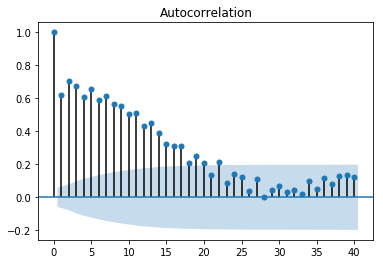

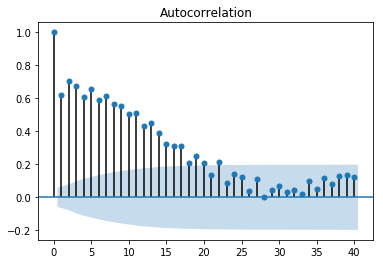

In [258]:
import statsmodels
ploty = statsmodels.tsa.stattools.ccf(testx,testy_)
plotx = testx.index

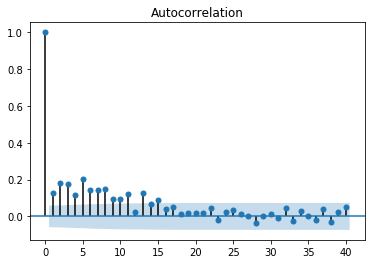

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(final_Xs[0]['3.0t-1gini_w'], lags=40)
plt.show()

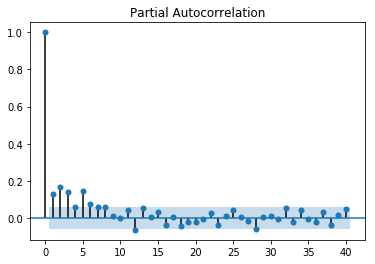

In [232]:
sm.graphics.tsa.plot_pacf(final_Xs[0]['3.0t-1gini_w'], lags=40)
plt.show()

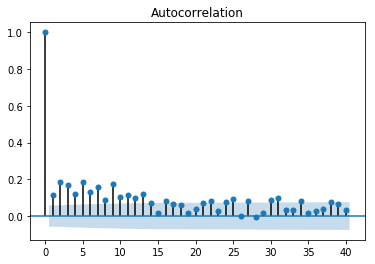

In [245]:
sm.graphics.tsa.plot_acf(np.abs(std_resid['log_return']).dropna(), lags=40)
plt.show()

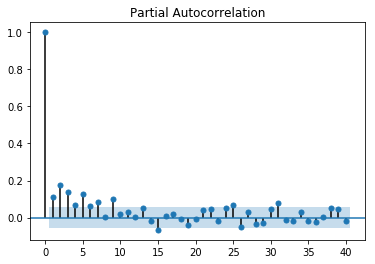

In [246]:
sm.graphics.tsa.plot_pacf(np.abs(std_resid['log_return']).dropna(), lags=40)
plt.show()

In [247]:
# np.log(np.abs(std_resid['log_return']) + 0.000001)
std_resid

Open         High          Low        Close    Adj Close  \
Date                                                                          
2015-09-09  21632.68945  22228.58984  21529.81055  22131.31055  22131.31055   
2015-09-10  21667.85938  21771.57031  21492.08984  21562.50000  21562.50000   
2015-09-11  21710.13086  21909.82031  21472.16016  21504.36914  21504.36914   
2015-09-14  21678.88086  21762.15039  21441.71094  21561.90039  21561.90039   
2015-09-15  21527.52930  21634.48047  21411.16992  21455.23047  21455.23047   
...                 ...          ...          ...          ...          ...   
2020-04-23  23983.65039  24107.88086  23806.30078  23977.32031  23977.32031   
2020-04-24  23844.55078  23957.16992  23730.49023  23831.33008  23831.33008   
2020-04-27  24030.66016  24318.81055  24030.53906  24280.14063  24280.14063   
2020-04-28  24401.11914  24582.66016  24176.88086  24575.96094  24575.96094   
2020-04-29  24786.01953  24855.47070  24549.61914  24643.58984  24643.58984   

                  Volume  log_return  std_resid  abs_resid  sq_resid  \
Date                                                                   
2015-09-09  2.945626e+09         NaN        NaN        NaN       NaN   
2015-09-10  2.092596e+09   -2.603768  -1.826700   1.826700  3.336834   
2015-09-11  2.371639e+09   -0.269956  -0.202376   0.202376  0.040956   
2015-09-14  1.472114e+09    0.267176   0.154947   0.154947  0.024009   
2015-09-15  1.352206e+09   -0.495943  -0.369928   0.369928  0.136846   
...                  ...         ...        ...        ...       ...   
2020-04-23  1.814345e+09    0.350783   0.171257   0.171257  0.029329   
2020-04-24  1.301665e+09   -0.610729  -0.364619   0.364619  0.132947   
2020-04-27  1.592713e+09    1.865765   1.053861   1.053861  1.110623   
2020-04-28  1.687557e+09    1.211001   0.677148   0.677148  0.458530   
2020-04-29  1.648009e+09    0.274805   0.139153   0.139153  0.019364   

            volatility  
Date                    
2015-09-09         NaN  
2015-09-10    1.446030  
2015-09-11    1.520201  
2015-09-14    1.481020  
2015-09-15    1.442549  
...                ...  
2020-04-23    1.828168  
2020-04-24    1.778362  
2020-04-27    1.734640  
2020-04-28    1.732715  
2020-04-29    1.703945  

[1145 rows x 11 columns]

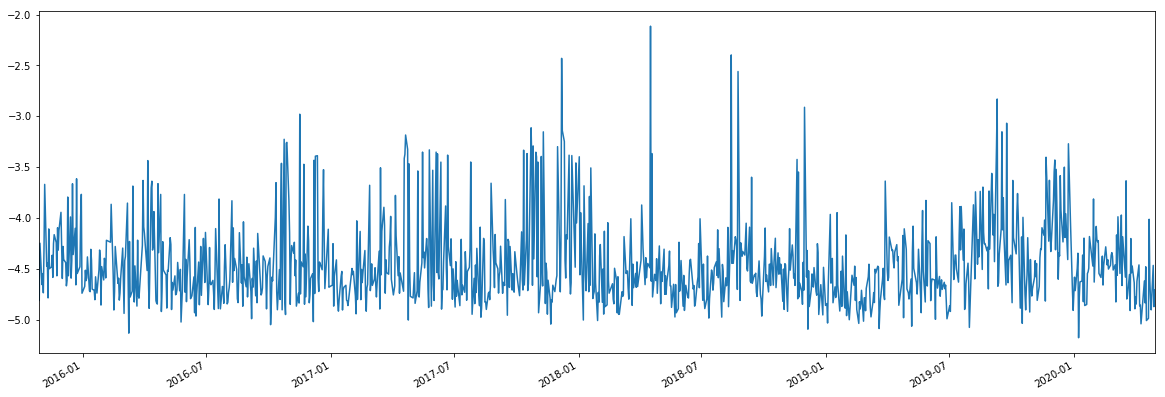

In [230]:
final_Xs[0]['3.0t-1gini_w'].plot(figsize=(20,7))

In [123]:
# # Select PCs for the topics
# proc_original_PCA = pd.DataFrame(output[0][:,:40], index = proc_original.index)
# proc_top_div_PCA = proc_top_gini
# proc_word_gini_PCA = pd.DataFrame(output[2][:,:55], index = proc_word_gini.index)
# proc_div_ranked_PCA = pd.DataFrame(output[3][:,:40], index = proc_div_ranked.index)

# Simulation (Not Used)

In [76]:
from sklearn.datasets import make_regression
sim_X, sim_Y = make_regression(1113, 10, 4)
sim_X = pd.DataFrame(sim_X, index = final_Xs[0].index)
sim_Y = pd.DataFrame(sim_Y, index = final_Xs[0].index)

In [88]:
df1 = sim_X.loc[:'2017-01-01']
df2 = sim_X.loc['2017-01-01':'2018-05-31']
df3 = sim_X.loc['2018-06-01':]

final_sim_X = pd.concat([df1,df2,df3], axis=0)

In [89]:
# Template for printing results for all models
Xs = [[final_sim_X]]

params_dicts = [
    {'decision_threshold':[0.05,0.1,0.15,0.2,0.25], 'n':[2], 'interaction_terms':[False]}
]


Ys = [sim_Y]
lag_one_y = [False]

model_names = ['Simulated Model']

window_size = [30, 60, 90]

Best model with these predictors are RMSE = 90.17529162602334, threshold = 0.05, n = 2, interaction terms = False
Directory exists! Writing to the directory.
NewY! 1 30 Simulated Model
/Users/JT/All Files/HKUST/BA Practicum/Data and Codes/Y1
------------------------------------------------------------------
number of models to be compared:  dict_keys([1])


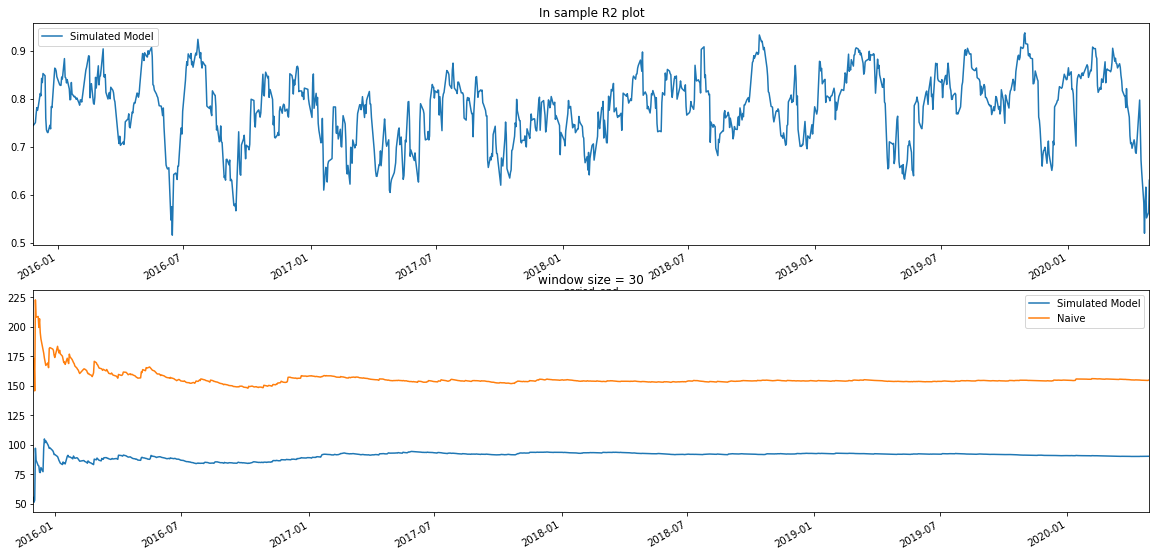

Best model with these predictors are RMSE = 87.24732759768844, threshold = 0.05, n = 2, interaction terms = False
Directory exists! Writing to the directory.
NewY! 1 60 Simulated Model
/Users/JT/All Files/HKUST/BA Practicum/Data and Codes/Y1
------------------------------------------------------------------
number of models to be compared:  dict_keys([1])


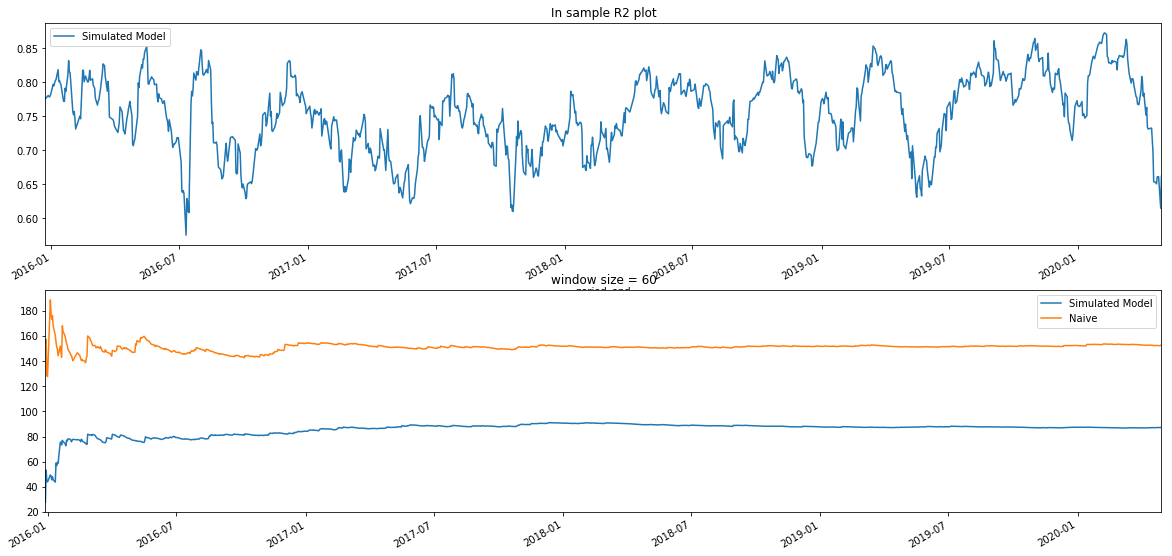

Best model with these predictors are RMSE = 83.8609941015722, threshold = 0.05, n = 2, interaction terms = False
Directory exists! Writing to the directory.
NewY! 1 90 Simulated Model
/Users/JT/All Files/HKUST/BA Practicum/Data and Codes/Y1
------------------------------------------------------------------
number of models to be compared:  dict_keys([1])


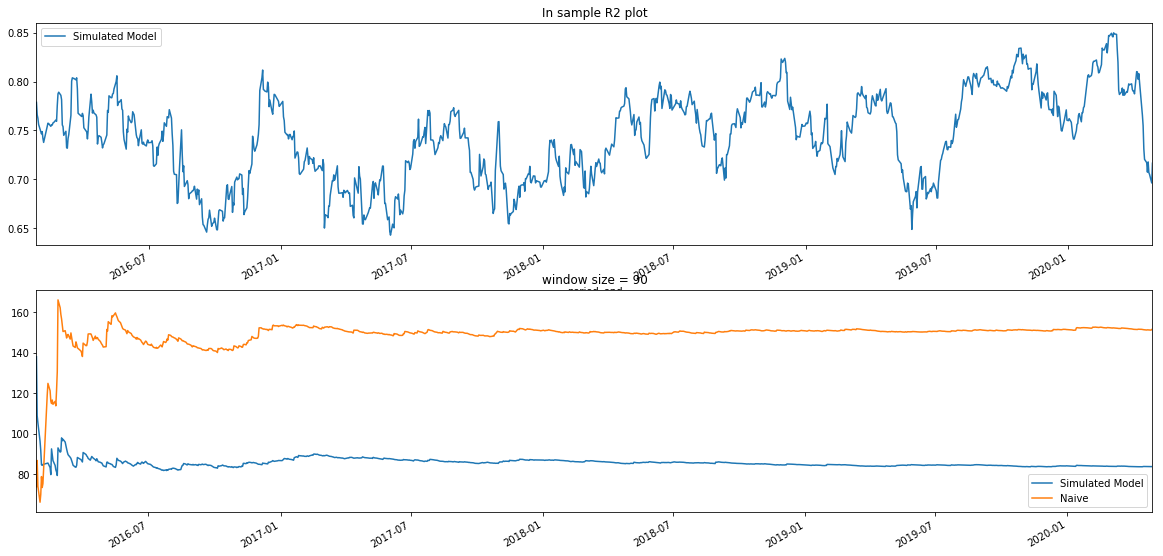

In [90]:
model_setting_4m = Regression('2015-10-29', '2020-04-29', 1)
result = model_setting_4m.fit_with_Experiments(Xs, Ys, model_names, params_dicts, window_size, lag_one_y, [7,15,30,45])

# Results

In [728]:
import pickle

# Get the useful info 
def testing(selected, threshold_analysis):
    analysis = selected[-1][0][['rsquare','Hybrid_Prediction','true_y', 'benchmark', 'Partial_F']]
    analysis.index = selected[-1][0]['prediction_date']
    analysis['RMSE'] = ((analysis['true_y'] - analysis['Hybrid_Prediction'])**2)
    analysis.loc[analysis['rsquare'] > threshold_analysis, 'chose_topic?'] = 1
    analysis.loc[analysis['rsquare'] < threshold_analysis, 'chose_topic?'] = 0
    analysis['model_performance'] = abs(analysis['true_y'] - analysis['Hybrid_Prediction'])
    analysis['benchmark_performance'] = abs(analysis['true_y'] - analysis['benchmark'])
    return analysis

def chosen_day_parameter_heatmap(model_result, threshold, show = 'chosen'):
    result_at_threshold = Regression.Threshold_Prediction_Impact(model_result, threshold)[-1][0]
    abs_error = np.abs(result_at_threshold['true_y'] - result_at_threshold['Hybrid_Prediction'])
    bench_error = np.abs(result_at_threshold['true_y'] - result_at_threshold['benchmark'])
    result_at_threshold['good_days'] = bench_error - abs_error
    good_days = list(result_at_threshold[result_at_threshold['good_days'] > 0]['period_end'])
    bad_days = list(result_at_threshold[result_at_threshold['good_days'] < 0]['period_end'])
    other_days = set(list(model_result[1].index)) - set(good_days) - set(bad_days)

    good_days_df = np.abs(model_result[1].loc[good_days])
    bad_days_df = -np.abs(model_result[1].loc[bad_days])
    other_days_df = pd.DataFrame(columns = model_result[1].columns, index = other_days)
    good_days_df.index = good_days_df.index.date
    bad_days_df.index = bad_days_df.index.date
    try:
        other_days_df.index = other_days_df.index.date
    except:
        pass
    good_x_bad = pd.concat([good_days_df,bad_days_df], axis = 0).sort_index()
    good_x_bad_x_other = pd.concat([good_days_df,bad_days_df, other_days_df], axis = 0).sort_index()

    fig, axs = plt.subplots(1,1, figsize = (20,10))
    if show == 'all':
        rolling_analysis.heatmap(good_x_bad_x_other.T, 0)
    elif show == 'chosen':
        rolling_analysis.heatmap(good_x_bad.T, 0)
    plt.gca().yaxis.grid(True, linestyle='--')
    
    return good_x_bad_x_other

def histogram(Y1, chosen):
    fig, ax = plt.subplots(1,1, figsize = (20,10))
    avg = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].mean()
    mdn = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].median()
    plt.hist(Y1.loc['2017-02-15':'2020-12-31']['abs_resid'], bins=200)

    labelled_r = 0
    labelled_k = 0

    for ix, row in chosen.iterrows():
        if chosen.loc[ix, 'better']:
            color = 'r'
            label = 'Prediction - better than benchmark'
            labelled_r += 1
        else:
            color = 'k'
            label = 'Prediction - worse than benchmark'
            labelled_k += 1
        if labelled_r == 1:
            labelled_r += 1
            plt.axvline(x=chosen.loc[ix, 'Hybrid_Prediction'], color=color, linestyle='dotted', linewidth=0.8, label=label)
        elif labelled_k == 1:
            labelled_k += 1
            plt.axvline(x=chosen.loc[ix, 'Hybrid_Prediction'], color=color, linestyle='dotted', linewidth=0.8, label=label)
        else:
            plt.axvline(x=chosen.loc[ix, 'Hybrid_Prediction'], color=color, linestyle='dotted', linewidth=0.8)

    plt.axvline(x=avg, color='green', linestyle='dotted', linewidth=4, label="Mean - {}".format(str(round(avg, 4))))
    plt.axvline(x=mdn, color='purple', linestyle='dotted', linewidth=4, label="Median - {}".format(str(round(mdn, 4))))
    plt.title('Better and worse predictions distributions', fontsize = 16)
    plt.legend(fontsize=16)
    plt.xlabel('Volatility measure in the timeframe (log absolute standardized GARCH residual)', fontsize=16)
    plt.ylabel('Number of appearance', fontsize=16)
    plt.show()
    
def confusion_matrix_data_cal(true_y, pred_y, cutoff):
    
    if true_y >= cutoff and pred_y >= cutoff:
        idx = 'high_high'

    elif true_y < cutoff and pred_y < cutoff:
        idx = 'low_low'

    elif true_y > cutoff and pred_y < cutoff:
        idx = 'high_low'

    elif true_y < cutoff and pred_y > cutoff:
        idx = 'low_high'
    
    return idx
    
def classification_table(Y1, chosen, cutoff):
#     avg = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].mean()
#     mdn = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].median()
    
    #             | Y_true_high  | Y_true_low
    # -----------------------------------------
    # Y_pred_high |              |
    # -----------------------------------------
    # Y_pred_low  |              |
    # -----------------------------------------
    
    confusion_dict = {
        'high_high' : [0,0],
        'low_low' : [0,0],
        'high_low' : [0,0],
        'low_high' : [0,0],
    }
    
    for ix, row in chosen.iterrows():
        true_y = chosen.loc[ix, 'true_y']
        pred_y = chosen.loc[ix, 'Hybrid_Prediction']
        better = chosen.loc[ix, 'better']
        bench_pred_y = chosen.loc[ix, 'benchmark']
        
        confusion_dict[confusion_matrix_data_cal(true_y, pred_y, cutoff)][0] += 1
#         if better:
#             confusion_dict[confusion_matrix_data_cal(true_y, pred_y, cutoff)][1] += 1
        confusion_dict[confusion_matrix_data_cal(true_y, bench_pred_y, cutoff)][1] += 1
                
    # maintain the spaces for better presentation
    spaces_1 = 8 - len(str(confusion_dict['high_high']))
    spaces_2 = 8 - len(str(confusion_dict['low_high']))

    print(
        "            |     Y_pred_high      |      Y_pred_low  \n"
        "-------------------------------------------------------------\n"
        "Y_true_high |       {}{}       |      {}     \n"
        "--------------------------------------------------------------\n"
        "Y_true_low  |       {}{}       |      {}     \n"
        "------------------------------------------------------------\n".format(str(confusion_dict['high_high']), 
                                                                                   ' '*spaces_1,
                                                                                str(confusion_dict['high_low']),
                                                                                str(confusion_dict['low_high']),
                                                                                   ' '*spaces_2,
                                                                                str(confusion_dict['low_low'])))
    
    # Precision recall of the model
    precision_recall(confusion_dict['high_high'][0], confusion_dict['low_high'][0], confusion_dict['high_low'][0], 'Model results')
    #     precision_recall(high_high[1], low_high[1], high_low[1], 'Better results')
    
    # Precision recall of the benchmark
    precision_recall(confusion_dict['high_high'][1], confusion_dict['low_high'][1], confusion_dict['high_low'][1], 'Benchmark results')
    print(" ")
                
        
def precision_recall(tp, fp, fn, label):
    precision = tp/(tp + fp)
    recall = tp/(tp+fn)
    
    print(label)
    print('precision: ', precision, '; recall: ', recall)
    print("=============================================\n")
    
    
def gen_wordcloud(text, label, ax):
    wordcloud = WordCloud(width = 500, height= 500, max_font_size=60, max_words=20, background_color='white')
    wordcloud.generate_from_frequencies(text)
    ax.imshow(wordcloud,interpolation="bilinear")
    ax.axis("off")
    ax.set_title(label)
    
def run_wordcloud(selected, chosen):

    procedure = selected[-1][0].set_index('prediction_date')
    procedure.index = pd.to_datetime(procedure.index)
    good_days = procedure.loc[chosen.index]

    fig = plt.figure(figsize=(15,200))
    counter = 0
    n = np.ceil(good_days.shape[0]/2)

    for ix, row in good_days.iterrows():
        start = good_days.loc[ix, 'period_start']
        end = good_days.loc[ix, 'period_end']
        ax = fig.add_subplot(n,2,counter+1)
        counter += 1

        # generate the dtm and remove by countvectorizer like what the model does
        test_text_df = trading_days.loc[start:end]
        vectorizer = CountVectorizer(max_df=0.1, min_df=0.001)
        X = vectorizer.fit_transform(test_text_df['content'].to_list())
        columns = vectorizer.get_feature_names()
        tf_matrix = X.toarray()
        tf = pd.DataFrame(tf_matrix, columns=columns)
        tf.index = test_text_df.index
        wordcloud_input = dict(tf.sum())

        gen_wordcloud(wordcloud_input, str(start)[:10] + '-' + str(end)[:10], ax)

    plt.savefig('wordcloud_for_used_days.png', bbox_inches = 'tight', pad_inches = 0)

def read_result(result_file, pred_file, Y1_file, window_size, model_num, threshold=None, wordcloud=False):
    """
        window_size = 30,60,90
        model_num = 1, 2, 3
    """
    
    model_dict = ['model-1', 'model-2', 'model-3']
    model_num = model_num - 1
    model_name = model_dict[model_num]
    
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
        
    with open(pred_file, 'rb') as f:
        Pred_Results = pickle.load(f)
        
    with open(Y1_file, 'rb') as f:
        Y1 = pickle.load(f)
    
    # Print the dataframe of the queried model
    accepted_df = Pred_Results[window_size][model_name][Pred_Results[window_size][model_name]['MAE_ratio'] > 1]
    print("_____________________ DF Accepted _____________________")
    print(accepted_df)
    print(' ')
    
    if not threshold:
        threshold = accepted_df.index.to_list()[0]
    
    selected = Regression.Threshold_Prediction_Impact(result[window_size][model_num][model_name] , threshold )
    
    print("_____________________ Test stat  _____________________")
    df_with_chose_topic = testing(selected, threshold)
    chosen = df_with_chose_topic[df_with_chose_topic['chose_topic?'] == 1]
    chosen[['model_performance', 'benchmark_performance']].boxplot()
    plt.show()
    print(stats.ttest_ind(chosen['benchmark_performance'], chosen['model_performance']))
    
    
    print("_____________________ Partial F Test  _____________________")
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    chosen[['Partial_F']].boxplot(figsize=(10,10), ax=axs[0])
    axs[0].set_title("Distribution of the p_values from Partial F-Test in the chosen days", fontsize=10)
    axs[0].set_ylim(0,0.2)
    df_with_chose_topic[df_with_chose_topic['chose_topic?']==0][['Partial_F']].boxplot(figsize=(10,10), ax=axs[1])
    axs[1].set_title("Distribution of the p_values from Partial F-Test in the not chosen days", fontsize=10)
    axs[1].set_ylim(0,0.2)
    plt.show()
    
    model_result = result[window_size][model_num][model_name]
    filtered_param_df = chosen_day_parameter_heatmap(model_result, threshold, show='chosen')
    
    print("_____________________ Distribution of predicted values  _____________________")
    chosen['better'] = (chosen['model_performance'] - chosen['benchmark_performance']) <= 0
    histogram(Y1, chosen)
    
    cutoff_avg = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].mean()
    cutoff_mdn = Y1.loc['2017-02-15':'2020-12-31']['abs_resid'].median()
    print("_____________________ Classification Table (Mean as cutoff) _____________________")
    classification_table(Y1, chosen, cutoff_avg)
    print("_____________________ Classification Table (Median as cutoff) _____________________")
    classification_table(Y1, chosen, cutoff_mdn)
    
    if wordcloud:
        print("_____________________ Word Cloud  _____________________")
        run_wordcloud(selected, chosen)
    
    return (accepted_df, selected, chosen)

In [732]:
accepted_df

RMSE_ratio  MAE_ratio  Cond_Prob_SE  Cond_Prob_AE  Cond_RMSE_ratio  \
0.45    0.998070   1.001872      0.537313      0.537313         0.965450   
0.46    0.998038   1.001901      0.540984      0.540984         0.963383   
0.47    0.998179   1.003413      0.580000      0.580000         0.958757   
0.48    0.997529   1.001132      0.536585      0.536585         0.938182   

      Cond_MAE_ratio  Cond_RMSE  Cond_MAE  Total_Days  Times_Topic_Model_SE  \
0.45        1.028736   1.061631  0.815169         913                    67   
0.46        1.031464   1.090113  0.830435         913                    61   
0.47        1.070530   1.094235  0.810359         913                    50   
0.48        1.026654   1.156571  0.869390         913                    41   

      Times_Topic_Model_AE  
0.45                    67  
0.46                    61  
0.47                    50  
0.48                    41

_____________________ DF Accepted _____________________
      RMSE_ratio  MAE_ratio  Cond_Prob_SE  Cond_Prob_AE  Cond_RMSE_ratio  \
0.45    0.998070   1.001872      0.537313      0.537313         0.965450   
0.46    0.998038   1.001901      0.540984      0.540984         0.963383   
0.47    0.998179   1.003413      0.580000      0.580000         0.958757   
0.48    0.997529   1.001132      0.536585      0.536585         0.938182   

      Cond_MAE_ratio  Cond_RMSE  Cond_MAE  Total_Days  Times_Topic_Model_SE  \
0.45        1.028736   1.061631  0.815169         913                    67   
0.46        1.031464   1.090113  0.830435         913                    61   
0.47        1.070530   1.094235  0.810359         913                    50   
0.48        1.026654   1.156571  0.869390         913                    41   

      Times_Topic_Model_AE  
0.45                    67  
0.46                    61  
0.47                    50  
0.48                    41  
 
____________________

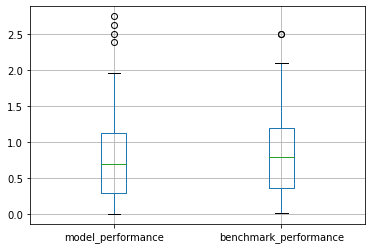

Ttest_indResult(statistic=0.2114690068577914, pvalue=0.8328474610088299)
_____________________ Partial F Test  _____________________


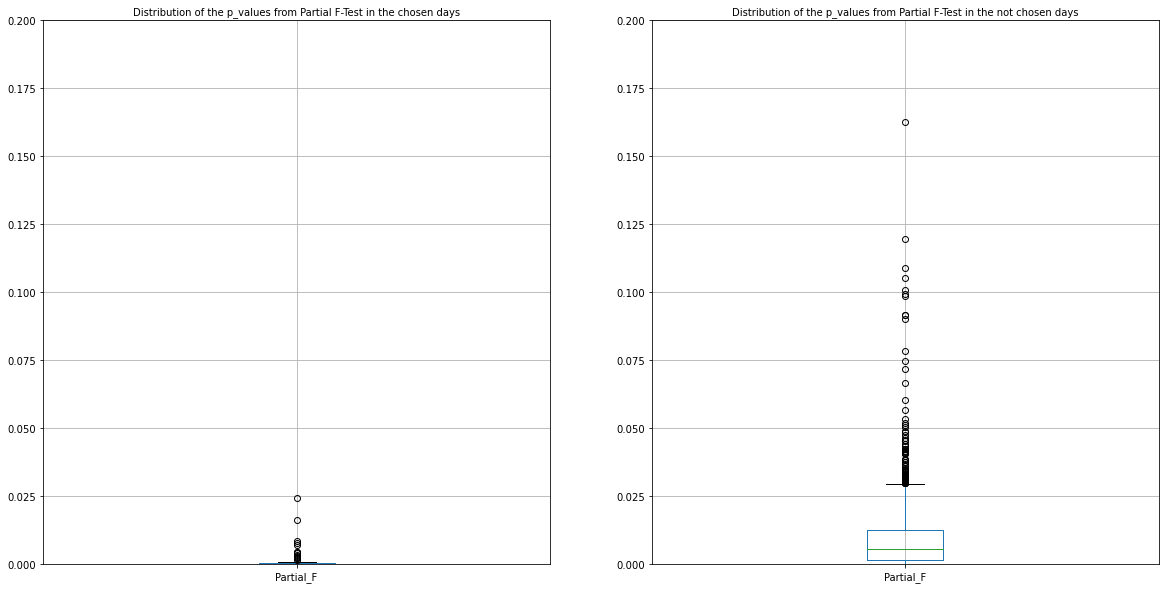

_____________________ Distribution of predicted values  _____________________


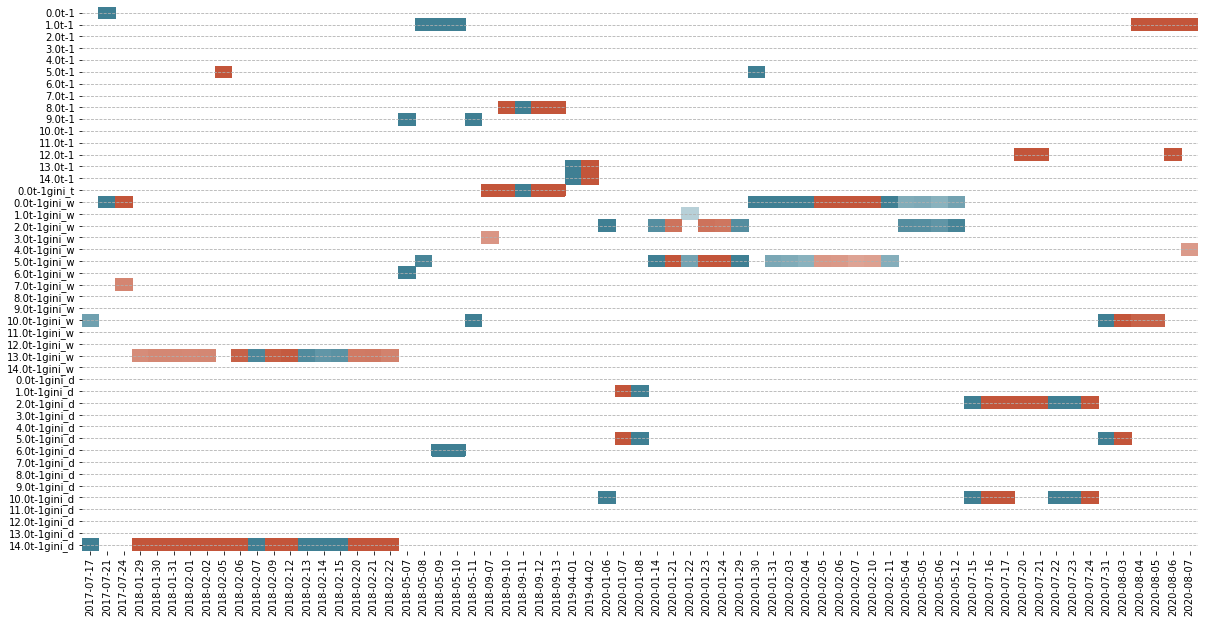

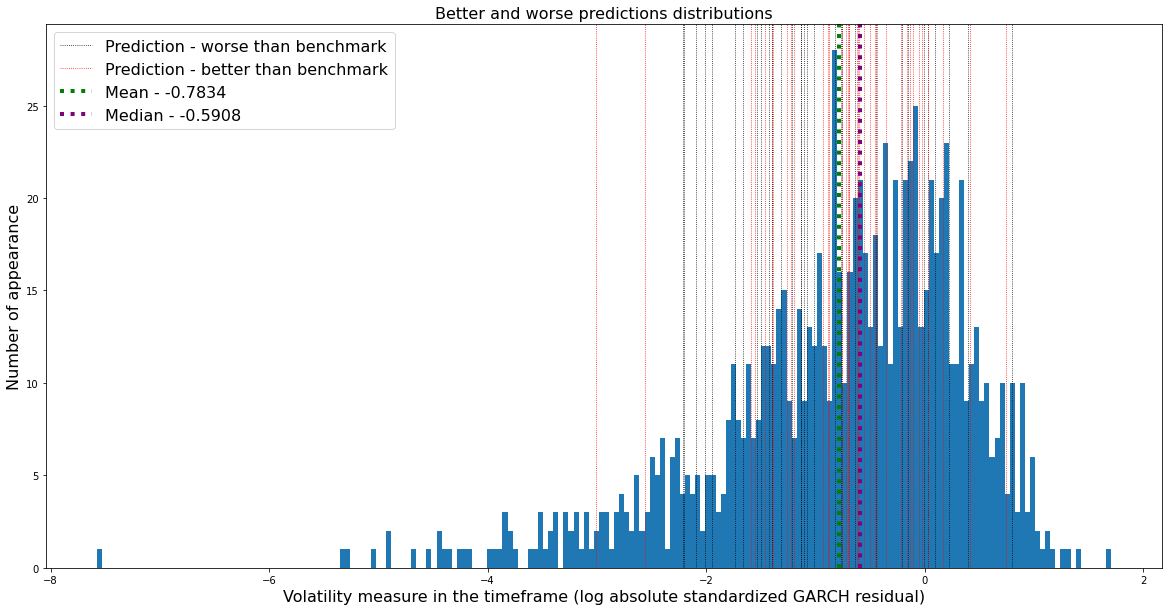

_____________________ Classification Table (Mean as cutoff) _____________________
            |     Y_pred_high      |      Y_pred_low  
-------------------------------------------------------------
Y_true_high |       [29, 16]       |      [15, 28]     
--------------------------------------------------------------
Y_true_low  |       [6, 6]         |      [17, 17]     
------------------------------------------------------------

Model results
precision:  0.8285714285714286 ; recall:  0.6590909090909091

Benchmark results
precision:  0.7272727272727273 ; recall:  0.36363636363636365

 
_____________________ Classification Table (Median as cutoff) _____________________
            |     Y_pred_high      |      Y_pred_low  
-------------------------------------------------------------
Y_true_high |       [18, 10]       |      [21, 29]     
--------------------------------------------------------------
Y_true_low  |       [6, 4]         |      [22, 24]     
-----------------------------

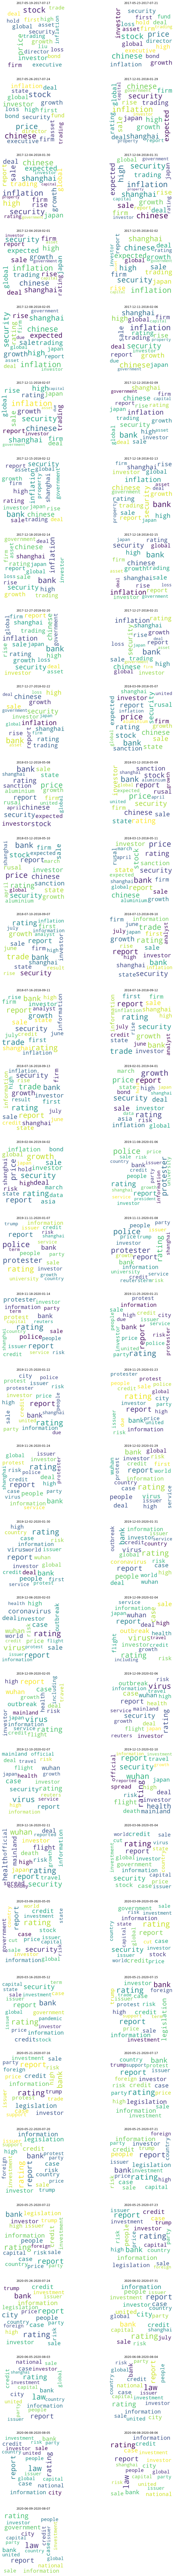

In [729]:
# (result_file, pred_file, Y1_file, window_size, model_num, threshold=None, wordcloud=False)
accepted_df, selected, chosen = read_result('tobeverified_yinrange.pkl', '202106121438-PREDRESULT.pkl', '202106121441-Y1.pkl', 60, 2, wordcloud=True)

In [15]:
with open('tobeverified_yinrange.pkl', 'rb') as f:
    result = pickle.load(f)

<AxesSubplot:>

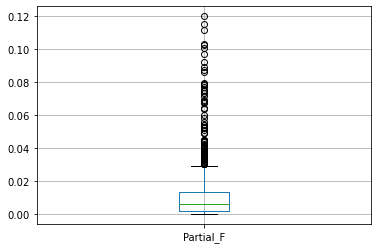

In [721]:
result[90][1]['model-2'][0][['Partial_F']].boxplot()

In [301]:
import pickle
# with open('Aug31-3model.pkl', 'wb') as f:
#     pickle.dump(result, f)
    
with open('QDwith0.3max_df.pkl', 'rb') as f:
     result03 = pickle.load(f)
        
with open('QDwith0.2max_df.pkl', 'rb') as f:
     result02 = pickle.load(f)
        
with open('merged_yinrange.pkl', 'rb') as f:
    result03 = pickle.load(f)

In [16]:
with open('tobeverified_yinrange.pkl', 'rb') as f:
    result = pickle.load(f)

In [17]:
Pred_Results = Regression.Model_Prediction_Comparison_Report(result, 0.1, 0.9, 0.01, show = False)

Directory exists! Writing to the directory.


In [18]:
Pred_Results

{30: {'model-1':       RMSE_ratio  MAE_ratio  Cond_Prob_SE  Cond_Prob_AE  Cond_RMSE_ratio  \
  0.10    0.910748   0.904306      0.439182      0.439182         0.910675   
  0.11    0.910748   0.904306      0.439182      0.439182         0.910675   
  0.12    0.910566   0.904029      0.438578      0.438578         0.910400   
  0.13    0.910551   0.903916      0.437972      0.437972         0.910381   
  0.14    0.910736   0.904320      0.437838      0.437838         0.910532   
  ...          ...        ...           ...           ...              ...   
  0.85    1.000000   1.000000      0.000000      0.000000              NaN   
  0.86    1.000000   1.000000      0.000000      0.000000              NaN   
  0.87    1.000000   1.000000      0.000000      0.000000              NaN   
  0.88    1.000000   1.000000      0.000000      0.000000              NaN   
  0.89    1.000000   1.000000      0.000000      0.000000              NaN   
  
        Cond_MAE_ratio  Cond_RMSE  Cond_MAE  T

In [142]:
final_result03 = result03[60][1]['model-2'] #0.52
final_result02 = result02[30][2]['model-3'] #0.85

In [725]:
with open('Aug31-3model.pkl', 'rb') as f:
    result = pickle.load(f)

Pred_Results = Regression.Model_Prediction_Comparison_Report(result, 0.1, 0.9, 0.01, show = False)



Directory exists! Writing to the directory.


In [97]:
# Pred_Results = Regression.Model_Prediction_Comparison_Report(result, 0.1, 0.9, 0.01, show = False)

In [143]:
selected03 = Regression.Threshold_Prediction_Impact(final_result03 , 0.52 )
selected02 = Regression.Threshold_Prediction_Impact(final_result02 , 0.85 )


In [548]:
selected = Regression.Threshold_Prediction_Impact(result[60][1]['model-2'] , 0.45 )

In [520]:
# Get the useful info 
def testing(selected, threshold_analysis):
    analysis = selected[-1][0][['rsquare','Hybrid_Prediction','true_y', 'benchmark', 'Partial_F']]
    analysis.index = selected[-1][0]['prediction_date']
    analysis['RMSE'] = ((analysis['true_y'] - analysis['Hybrid_Prediction'])**2)
    analysis.loc[analysis['rsquare'] > threshold_analysis, 'chose_topic?'] = 1
    analysis.loc[analysis['rsquare'] < threshold_analysis, 'chose_topic?'] = 0
    analysis['model_performance'] = abs(analysis['true_y'] - analysis['Hybrid_Prediction'])
    analysis['benchmark_performance'] = abs(analysis['true_y'] - analysis['benchmark'])
    return analysis

Ttest_indResult(statistic=0.37886967840156255, pvalue=0.7053933549734498)

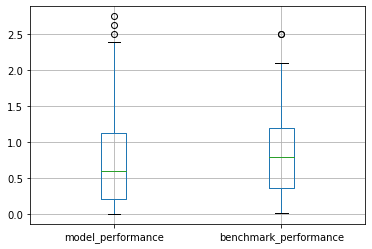

In [538]:
from scipy import stats
# analysis02 = test(selected02, 0.85)
# analysis03 = test(selected03, 0.52)
# test = pd.concat([analysis02,analysis03])
# test.drop(test.loc['2020-01-31'].index, inplace=True)
test = testing(selected, 0.45)

better = test[test['chose_topic?'] == 1]
better[['model_performance', 'benchmark_performance']].boxplot()
stats.ttest_ind(better['benchmark_performance'], better['model_performance'])

In [581]:
test = testing(selected, 0.45)

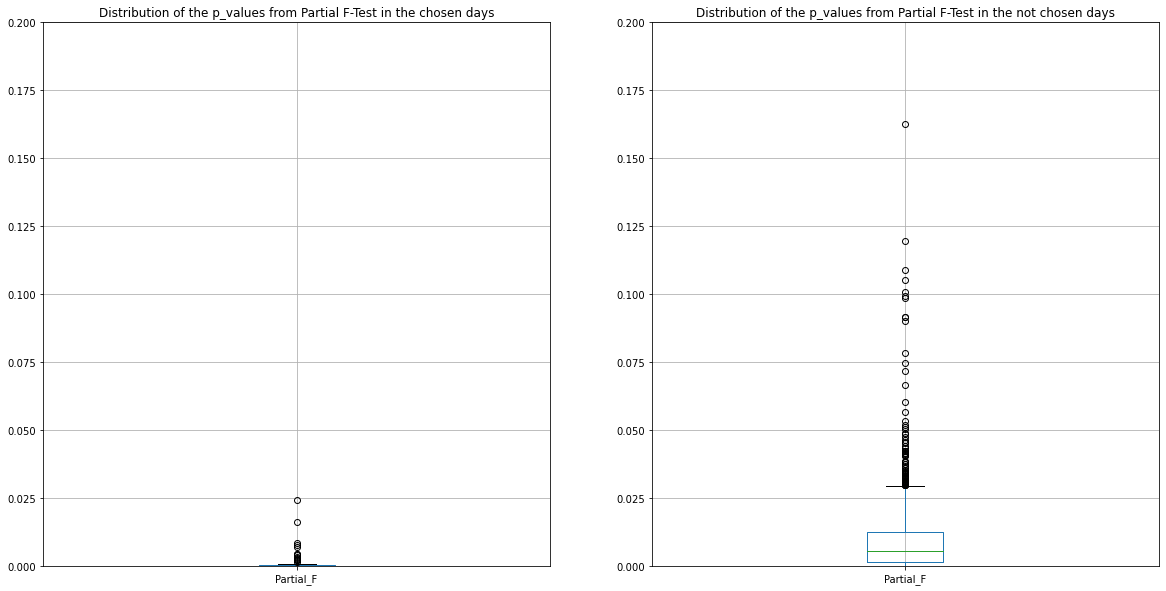

In [584]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
better[['Partial_F']].boxplot(figsize=(10,10), ax=axs[0])
axs[0].set_title("Distribution of the p_values from Partial F-Test in the chosen days")
axs[0].set_ylim(0,0.2)

test[test['chose_topic?']==0][['Partial_F']].boxplot(figsize=(10,10), ax=axs[1])
axs[1].set_title("Distribution of the p_values from Partial F-Test in the not chosen days")
axs[1].set_ylim(0,0.2)

plt.show()

In [81]:
# Regression.timeseries_plot_for_results(analysis, show_HSI=True, show_return = True, show_volume = True)

In [493]:
Pred_Results = Regression.Model_Prediction_Comparison_Report(result, 0.1, 0.9, 0.01, show = False)

Directory exists! Writing to the directory.


In [591]:
#0.4 threhold
Pred_Results[60]['model-2'][Pred_Results[60]['model-2']['MAE_ratio'] > 1]

Empty DataFrame
Columns: [RMSE_ratio, MAE_ratio, Cond_Prob_SE, Cond_Prob_AE, Cond_RMSE_ratio, Cond_MAE_ratio, Cond_RMSE, Cond_MAE, Total_Days, Times_Topic_Model_SE, Times_Topic_Model_AE]
Index: []

In [585]:
accepted = Pred_Results[60]['model-2'][Pred_Results[60]['model-2']['MAE_ratio'] > 1]

In [588]:
accepted

Empty DataFrame
Columns: [RMSE_ratio, MAE_ratio, Cond_Prob_SE, Cond_Prob_AE, Cond_RMSE_ratio, Cond_MAE_ratio, Cond_RMSE, Cond_MAE, Total_Days, Times_Topic_Model_SE, Times_Topic_Model_AE]
Index: []